<a href="https://colab.research.google.com/github/mahaley22/Uncertainty-Sampling/blob/master/Machine_Translation_with_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####   **Using Uncertainty Scoring for a Seq2seq MT model**  
2020 Mike Haley.




(Adapted from:      <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Neural machine translation with attention</a>)

In [ ]:
lo

This notebook trains a sequence to sequence (seq2seq) model for machine translation, using Attention. However, instead of looking at the Attention plots, we will be looking at a whole lot of Uncertainty plots and aggregating by uncertainty to reveal some directions for analyzing avoidable bias, variance, and sampling for Active Learning.  

This work was inspired in part by *Human-in-the-Loop Machine Learning* by Robert Munro © 2020  The reader of this notebook can skip down to the sections where the bulk of my work begins [Translate (with Uncertainty!)](#Translate).

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?   Attribution: tatoeba.org #2245231 (CK) & #6077611 (fekundulo)
```


To import the training and validation data, (which we want to have even if we've already saved off a model), you'll have to run something like the following two cells.   If you want to just go with the spanish language as was originally used in the original notebook (referenced at the top of this notebook) there may be no need to download the file into a google drive folder somewhere.  I've had trouble doing so outside of the original notebook, but leave the option in the code below.  I happened change the original source input language from Spanish to Hebrew as a first go, but you might want to replace that below.


In [3]:
source_lang='heb'

In [4]:
if source_lang!='spa':
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Download the file
def get_path_to_file(lang='spa'):
  if lang=='spa':  
    path_to_zip = tf.compat.v2.keras.utils.get_file(
      'spa-eng.zip', origin='https://drive.google.com/file/d/1X5vqyh0bVii_VLcC9uEY7JzruFlMnBCS/view?usp=sharing',
      extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file
  else: #your own google drive
    import zipfile
    my_colab_folder = "/content/drive/My Drive/Colab Notebooks"
    with zipfile.ZipFile(my_colab_folder + "/"+source_lang+"-eng.zip", 'r') as zip_ref:
      zip_ref.extractall(my_colab_folder)
    path_to_file = my_colab_folder+"/"+source_lang+".txt"
    return path_to_file

In [6]:
path_to_file = get_path_to_file(source_lang)
path_to_file

'/content/drive/My Drive/Colab Notebooks/heb.txt'

In [7]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w, lang):
  w = w.lower().strip() 
  if source_lang=="spa":
    unicode_to_ascii(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",") - this is source langauge-specific! hence the conditional placeholder
  if source_lang=="spa": 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [8]:
english_sentence = u"We ate.	"
source_sentence = u"אכלנו."
print(preprocess_sentence(english_sentence, source_lang))
source_sentence = preprocess_sentence(source_sentence, source_lang)
if source_lang=="spa": #use for other languages as well
  source_sentence.encode('utf-8')
print(source_sentence)

<start> we ate . <end>
<start> אכלנו . <end>


In [9]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SOURCE]
def create_dataset(path, num_examples):
  lines = io.open(path).read().strip().split('\n')#io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w, source_lang) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  #print(word_pairs[-1])

  return zip(*word_pairs)

In [10]:
english, source = create_dataset(path_to_file, None)
print(english[-1])
print(source[-1])

<start> if someone who doesn't know your background says that you sound like a native speaker , it means they probably noticed something about your speaking that made them realize you weren't a native speaker . in other words , you don't really sound like a native speaker . <end>
<start> אם מישהו שאינו מכיר את הרקע שלכם אומר שאתם נשמעים כמו דוברים ילידים , פירוש הדבר שהוא מן הסתם הבחין במשהו בדיבורכם שגרם לו להבין שאינכם דוברים ילידים . במילים אחרות , אתם לא באמת נשמעים כמו דוברים ילידים . <end>


In [11]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  print(inp_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [13]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

('<start> היי . <end>', '<start> אהלן . <end>', '<start> רוץ ! <end>', '<start> רוצי ! <end>', '<start> רוצו ! <end>', '<start> מי ? <end>', '<start> וואו ! <end>', '<start> ואו ! <end>', '<start> אש ! <end>', '<start> שריפה ! <end>', '<start> הצילו ! <end>', '<start> קפוץ . <end>', '<start> עצור ! <end>', '<start> חכה ! <end>', '<start> תמשיך . <end>', '<start> תמשיכי . <end>', '<start> תמשיכו . <end>', '<start> היי . <end>', '<start> אהלן . <end>', '<start> רצתי . <end>', '<start> אני מבין . <end>', '<start> אני מבינה . <end>', '<start> אני רואה . <end>', '<start> אני מבין <end>', '<start> אני מנסה . <end>', '<start> אני משתדלת . <end>', '<start> אני משתדל . <end>', '<start> ניצחתי ! <end>', '<start> זכיתי ! <end>', '<start> ניצחתי . <end>', '<start> הו , לא ! <end>', '<start> אוי לא ! <end>', '<start> תירגע . <end>', '<start> חייכי . <end>', '<start> חייך . <end>', '<start> תקוף ! <end>', '<start> לחיים ! <end>', '<start> אל תזוזו ! <end>', '<start> עצרו במקום ! <end>', '<start> עמד

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1669 ----> התלבש
103 ----> מהר
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
56 ----> get
855 ----> dressed
288 ----> quickly
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#print(example_target_batch[0:])

(TensorShape([64, 11]), TensorShape([64, 10]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) 

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
tf.expand_dims?


In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [24]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5303)


## Define the optimizer and the loss function

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [27]:
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

<a id="Training"></a>
## Training

Details of training for this interested from original attention notebook:
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [46]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [47]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1831
Epoch 1 Batch 100 Loss 0.3271
Epoch 1 Batch 200 Loss 0.2888
Epoch 1 Batch 300 Loss 0.2615
Epoch 1 Loss 0.2648
Time taken for 1 epoch 42.4506356716156 sec

Epoch 2 Batch 0 Loss 0.1013
Epoch 2 Batch 100 Loss 0.1031
Epoch 2 Batch 200 Loss 0.0908
Epoch 2 Batch 300 Loss 0.0976
Epoch 2 Loss 0.1398
Time taken for 1 epoch 33.10562181472778 sec

Epoch 3 Batch 0 Loss 0.0855
Epoch 3 Batch 100 Loss 0.1066
Epoch 3 Batch 200 Loss 0.1149
Epoch 3 Batch 300 Loss 0.0558
Epoch 3 Loss 0.0929
Time taken for 1 epoch 32.36825132369995 sec

Epoch 4 Batch 0 Loss 0.0536
Epoch 4 Batch 100 Loss 0.0421
Epoch 4 Batch 200 Loss 0.0680
Epoch 4 Batch 300 Loss 0.0555
Epoch 4 Loss 0.0735
Time taken for 1 epoch 33.59688878059387 sec

Epoch 5 Batch 0 Loss 0.0381
Epoch 5 Batch 100 Loss 0.0904
Epoch 5 Batch 200 Loss 0.0698
Epoch 5 Batch 300 Loss 0.0883
Epoch 5 Loss 0.0635
Time taken for 1 epoch 32.3964958190918 sec

Epoch 6 Batch 0 Loss 0.0556
Epoch 6 Batch 100 Loss 0.0412
Epoch 6 Batch 200 Loss 0

In [ ]:
# since this is a custom training loop, cannot use below.  
# (cf. Chapter 6 Deep Learning With Python (2nd edition))
#loss_and_metrics = decoder.evaluate(input_tensor_val, target_tensor_val, batch_size=128)


<a id=’Translate’></a>
##Translate (with Uncertainty!)

Here's where the fun begins.  Instead of keeping the attention weights around in order to plot them, we're going to use the final layer outputs in the following way:
* softmax normalization to yield a "probabilistic" uncertainty score.
* For every timestamp, we also remember the "runner-up" token.  This proves useful as some translations a high "runner-up" score can show us an alternate (acceptable) translation for that token, and also why there may be uncertainty
* We store scores for most confidence, Margin of Confidence between the first and second "score", and a combination (multiplicaton) of the two as our third plot.
* Later on, we will take an average across the entire sequence as an aggregate measure of sequence confidence.



In [48]:
def get_uncertainty_metrics(uncertainty_scores, t, softmax_output):  
    sorted_scores = tf.sort(softmax_output, direction='DESCENDING')
    predicted_probability_score = sorted_scores[0].numpy()
    
    # 1. Least Confidence 
    #   here I did not bother to add the * (num_labels/(numlabels-1) as numlabels is equal to (large) vocab size)
    least_confidence = (1 - predicted_probability_score) 
    uncertainty_scores[t,0] = least_confidence

    # 2. Margin of Confidence
    margin = sorted_scores[0].numpy() - sorted_scores[1].numpy()   
    margin_of_confidence_score = (1-margin)
    uncertainty_scores[t,1] = margin_of_confidence_score

    # 3 Combined 
    combined_uncertainty_score = (1 - predicted_probability_score*margin)
    uncertainty_scores[t,2] = combined_uncertainty_score

    #print("For token: '" + predicted_word + "', probability score is: " + str(predicted_probability_score) +
    #      ", and Uncertainty Score: " + uncertainty_score + ", and Combined Uncertainty Score: " + str(combined_uncertainty_score)) 
    return uncertainty_scores 

For those interested or as a reference, here are some details from the original attention nb:
* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*. - NOT USED HERE

Note: The encoder output is calculated only once for one input.

In [49]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence, source_lang)
  uncertainty_scores = np.zeros((max_length_targ, 3)) 

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  runner_up_result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on - NOT USED HERE
    #attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

    # Here's where we use softmax (post-optimization) on the raw logits 
    softmax_output = tf.nn.softmax(predictions[0])

    uncertainty_scores = get_uncertainty_metrics(uncertainty_scores, t, softmax_output)

    ranking = tf.argsort(softmax_output, direction='DESCENDING')
    predicted_id = ranking[0].numpy() #equivalent to tf.argmax(softmax_output).numpy()
    runner_up_id = ranking[1].numpy()
    predicted_word = targ_lang.index_word[predicted_id]
    runner_up_word = targ_lang.index_word[runner_up_id] 

    result += predicted_word + ' '
    runner_up_result += runner_up_word + ' '

    if predicted_word == '<end>':
      return result, runner_up_result, sentence, uncertainty_scores

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, runner_up_result, sentence, uncertainty_scores

In [50]:
#Below thresholds are arbitrary and are really for bar chart colors only.  We'll get to optimization later!
high_confidence_threshold = 0.67
medium_confidence_threshold = 0.33

In [51]:
def label_bar(ax, plots):  
  for bar in plots:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, '{:.2g}'.format(yval), va='bottom') #va: vertical alignment y positional argument

# function for plotting the certainty scores
def plot_uncertainty(scores, titles, predicted_sentence):
  tokens = tuple(predicted_sentence)
  x = np.arange(len(tokens))
  plt.rcParams["figure.figsize"] = [5*1.618,2.5]
  fig, ax = plt.subplots(1, len(scores[1]))
  plt.ylabel = "Uncertainty" #TODO don't know why this doesn't show up in left Y margin
  
  for p in range(len(scores[1])):
    y = scores[:, p]

    mask_red = y > high_confidence_threshold
    mask_yellow = np.logical_and(y >= medium_confidence_threshold, y < high_confidence_threshold)
    mask_green = y < medium_confidence_threshold

    ax[p].set_ylim([0, 1])
    red_plots = ax[p].bar(x[mask_red], y[mask_red], color = 'red')
    label_bar(ax[p], red_plots)
    yellow_plots = ax[p].bar(x[mask_yellow], y[mask_yellow], color = 'yellow')
    label_bar(ax[p], yellow_plots)
    green_plots = ax[p].bar(x[mask_green], y[mask_green], color = 'green')
    label_bar(ax[p], green_plots)

    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].set_title(titles[p])

  #plt.title('Output: {}'.format(predicted_sentence))
  plt.show()

In [52]:
def translate(sentence, verbose=True):
  result, runner_up, sentence, scores = evaluate(sentence)
  tokenized_result = [t for t in result.split(' ') if t] 
  if verbose:
    print('\nInput: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Runner-up translation: {}'.format(runner_up))
    titles = []
    titles.append('Least Conf')
    titles.append('Margin of Conf')
    titles.append('Combined Conf')
    uncertainty_plot = scores[:len(tokenized_result)]
    plot_uncertainty(uncertainty_plot, titles, tokenized_result)
  else: 
    return scores, tokenized_result

## Restore the latest checkpoint and run a few sample translations
Bear in mind your model depends on the train/val distribution, so results may vary (feel free to input anything here and see what happens!).  Bear in mind that every source has one possible target (we don't have alternate reference translations).  Note in some cases that the **runner-up translation** token can explain some of the uncertainty in some cases.

In [72]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Target: Can I use this bike?

Input: <start> מותר לי להשתמש באופניים ? <end>
Predicted translation: can i use this bike ? <end> 
Runner-up translation: may buy count sugar ? in ? 


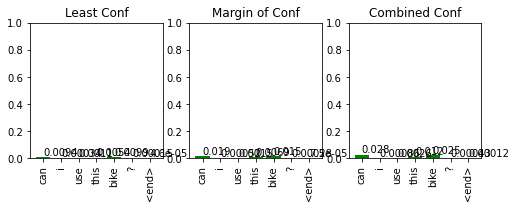

In [73]:
# here we see the 'may' vs. 'can' uncertainty, depending on the training 
print("Target: Can I use this bike?") 
translate(u'מותר לי להשתמש באופניים?')

Target: Is anything wrong?

Input: <start> משהו לא בסדר ? <end>
Predicted translation: is something wrong ? <end> 
Runner-up translation: was anything ok ok ? 


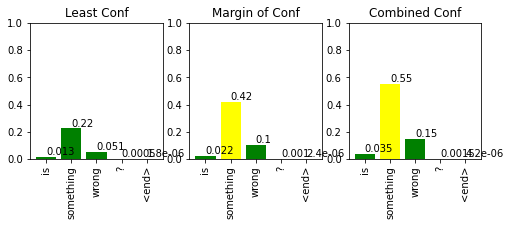

In [74]:
#"Anything" vs. "something" uncertainty 
print("Target: Is anything wrong?")
translate(u'משהו לא בסדר?')

Target: Is this our flight?

Input: <start> זאת הטיסה שלנו ? <end>
Predicted translation: is that our book ? <end> 
Runner-up translation: will this book sister . ? 


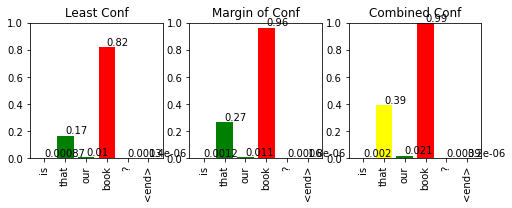

In [116]:
 # note the "this" versus "that" uncertainty.  In my run it got "Is this our book" but "book" has very high uncertainty
 print("Target: Is this our flight?")
 translate(u'זאת הטיסה שלנו?')

Target: Stop grumbling.

Input: <start> תפסיק להתלונן . <end>
Predicted translation: quit complaining . <end> 
Runner-up translation: stop is ! i 


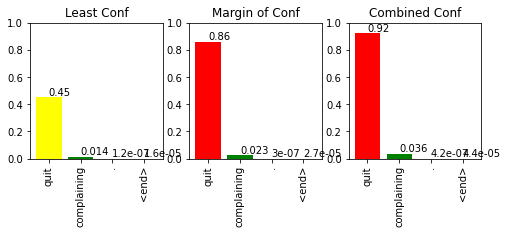

In [117]:
# "grumbling" vs. "complaining" uncertainty sometimes, "quit" vs. "stop" other times
print("Target: Stop grumbling.")
translate(u'תפסיק להתלונן.')



Target: Do you see it?

Input: <start> אתה רואה את זה ? <end>
Predicted translation: do you see it ? <end> 
Runner-up translation: can i do that up him 


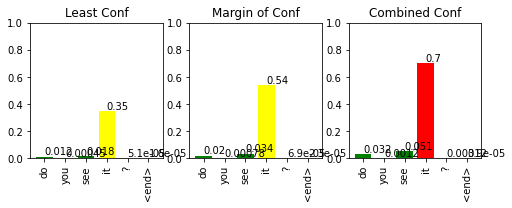

In [77]:
#"it" versus "that"
print("Target: Do you see it?")
translate(u'אתה רואה את זה?')

##Towards Uncertainty (and Certainty) Sampling
Now that we've seen some interesting values for individual translation tokens, we're ready to approach some uncertainty sampling using an aggregation across the entire sequence.

Let's just start with the admittedly guess-timated thresholds below
and equally sized subsets of both our training and validation sets for testing against these thresholds.

In [62]:
total_test_size=1000
uncertainty_sampling_treshold = 0.2
certainty_sampling_treshold = 0.02

In [65]:
#Some table-setting functions we'll need:

def convert_to_sentence(lang, tensor):
  sentence = "";
  for t in tensor:
    if t not in [0, 1, 2]:
      sentence = sentence + ' ' + lang.index_word[t]
  return sentence

def translate_sentences(inp_lang, targ_lang, input_tensor, target_tensor, range, verbose=True):
  scores = []
  results = []
  for s in range:
    input_sentence = convert_to_sentence(inp_lang, input_tensor[s])
    target_sentence = convert_to_sentence(targ_lang, target_tensor[s])
    if verbose:
      print("\n\nSentence: " + input_sentence)
      print("Target: " + target_sentence)
    score, result = translate(input_sentence, verbose)
    scores.append(score)
    results.append(result)
  return np.array(scores), np.array(results)



In [64]:
def get_high_uncertainty_sample_size(sequence_mean, threshold = uncertainty_sampling_treshold):
  mask_uncertainty = sequence_mean > threshold
  uncertainty_sample = sequence_mean[mask_uncertainty]
  uncertainty_sample_size = len(uncertainty_sample)
  print("Uncertainty set size: " + str(uncertainty_sample_size) + " out of " + str(len(sequence_mean)))
  return uncertainty_sample_size

def get_low_uncertainty_sample_size(sequence_mean, threshold = certainty_sampling_treshold):
  mask_uncertainty = sequence_mean < threshold
  certainty_sample = sequence_mean[mask_uncertainty]
  certainty_sample_size = len(certainty_sample)
  print("Certainty subset size: " + str(certainty_sample_size) + " out of " + str(len(sequence_mean)))
  return certainty_sample_size

Depending on the size of the test (above) the two cells below  may take a minute or two each for 1000 translations on a GPU.   

In [66]:
score_plots, training_results = translate_sentences(inp_lang, targ_lang, input_tensor_train, target_tensor_train, range(total_test_size), verbose=False)
set_mean = tf.math.reduce_mean(score_plots, axis=[0,1])
print("Training set uncertainty means: " + str(set_mean.numpy()))
training_sequences_means = tf.math.reduce_mean(score_plots[:,:,-1], axis=1).numpy() #sequence mean as our sample aggregation function TODO consider using minimum
training_high_uncertainty_sample_size = get_high_uncertainty_sample_size(training_sequences_means)
training_low_uncertainty_sample_size = get_low_uncertainty_sample_size(training_sequences_means)

Training set uncertainty means: [0.01202121 0.01962307 0.02643446]
Uncertainty set size: 4 out of 1000
Certainty subset size: 648 out of 1000


In [67]:
score_plots, val_results = translate_sentences(inp_lang, targ_lang, input_tensor_val, target_tensor_val, range(total_test_size), verbose=False)
set_mean = tf.math.reduce_mean(score_plots, axis=[0,1])
print("Validation set uncertainty means: " + str(set_mean.numpy()))
val_sequences_means = tf.math.reduce_mean(score_plots[:,:,-1], axis=1).numpy() #sequence mean as our sample aggregation function
val_high_uncertainty_sample_size = get_high_uncertainty_sample_size(val_sequences_means)
val_low_uncertainty_sample_size = get_low_uncertainty_sample_size(val_sequences_means)


Validation set uncertainty means: [0.0490377  0.07113168 0.08741677]
Uncertainty set size: 84 out of 1000
Certainty subset size: 235 out of 1000


Not surprisingly:
* the overall uncertainty means are higher for the validation set
* the "certain" cohort is larger for the training set versus the validation set.

### Exploring Underfitting and (Un)certainty
So to look for avoidable bias (underfitting), now let's take a look at which of our confident mis-matches (at least according to our crude 1-1 matching algorithm with no alternate reference translations considered):

In [68]:

def get_ranked_uncertainty(sequences_means, size, target_tensor=None, input_tensor=None, 
                           direction='DESCENDING', display=True, ranking=None, results=None,  targ_lang=targ_lang):
  matches = []
  non_matches = []
  if ranking is None:
    ranking = tf.argsort(sequences_means, direction=direction)
  for u in range(size): 
    target = convert_to_sentence(targ_lang, target_tensor[ranking[u]])
    if display:
      print("\n\nTarget: " + target)
      print("Aggregate Sequence Uncertainty: " + str(sequences_means[ranking[u]]))
      translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]))
    else:
      tokenized_result = results[ranking[u]] #_, tokenized_result = translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]), verbose=False)
      if "<end>" in tokenized_result:
        tokenized_result.remove('<end>')
      if ' '.join(tokenized_result).strip() == target.strip():
        matches.append(ranking[u])
      else:
        #print(' '.join(tokenized_result).strip()) - if you want to display the non-match inline
        #print(target.strip())
        non_matches.append(ranking[u])
  return np.array(matches), np.array(non_matches)


In [107]:
training_matches, training_non_matches = get_ranked_uncertainty(training_sequences_means, training_low_uncertainty_sample_size, target_tensor_train,
                                              direction='ASCENDING', display=False, results=training_results)
print("Training set confident matches: " + str(len(training_matches)))
print("Training set confident non-Matches: " + str(len(training_non_matches)))
print("Matching: {:.1%}".format((len(training_matches)/(len(training_matches)+len(training_non_matches)))))

Training set confident matches: 632
Training set confident non-Matches: 16
Matching: 97.5%


Yay!  A high percentage of matches (accuracy) in the large highly confident set is what we like to see.  Let's look at the non-matches:


Target:  the war had ended .
Aggregate Sequence Uncertainty: 0.003112560510635376

Input: <start> המלחמה תמה . <end>
Predicted translation: the war ended . <end> 
Runner-up translation: someone man has ended fuji 


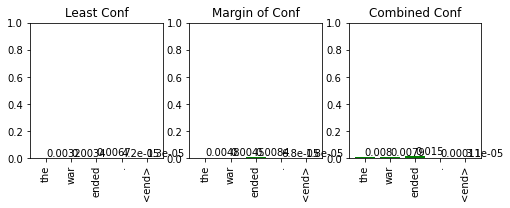


Target:  tom gasped for air .
Aggregate Sequence Uncertainty: 0.0032425165176391602

Input: <start> תום נאבק לנשום . <end>
Predicted translation: tom is winded . <end> 
Runner-up translation: they gasped bipolar <end> mary 


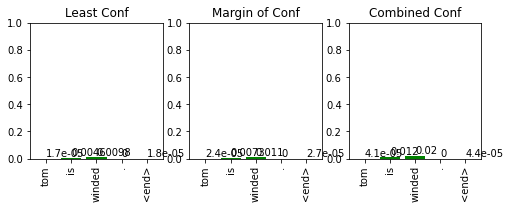


Target:  tom remembered .
Aggregate Sequence Uncertainty: 0.003698903322219849

Input: <start> תום נזכר . <end>
Predicted translation: tom remembers . <end> 
Runner-up translation: tom's remembered me mary 


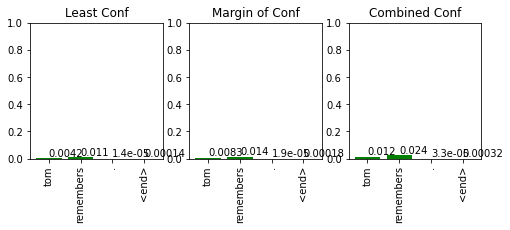


Target:  it was gross .
Aggregate Sequence Uncertainty: 0.0037865519523620607

Input: <start> זה היה מגעיל . <end>
Predicted translation: it was disgusting . <end> 
Runner-up translation: i made gross ! i 


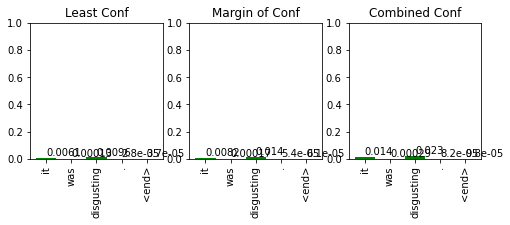


Target:  please come in .
Aggregate Sequence Uncertainty: 0.009319746494293213

Input: <start> תכנס בבקשה . <end>
Predicted translation: please come . <end> 
Runner-up translation: come step in . 


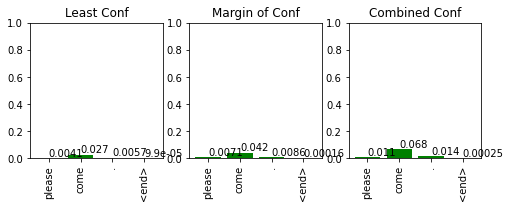


Target:  he raised his arm .
Aggregate Sequence Uncertainty: 0.009716325998306274

Input: <start> הוא הרים את ידו . <end>
Predicted translation: he raised his hand . <end> 
Runner-up translation: his fixed my job me fuji 


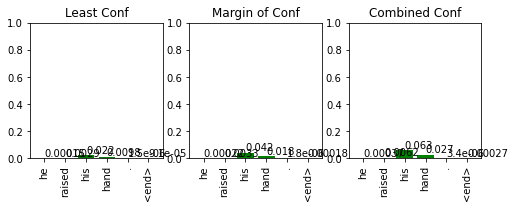


Target:  i saw a plane .
Aggregate Sequence Uncertainty: 0.009846711158752441

Input: <start> ראיתי אווירון . <end>
Predicted translation: i saw an airplane . <end> 
Runner-up translation: i've made my addict tire myself 


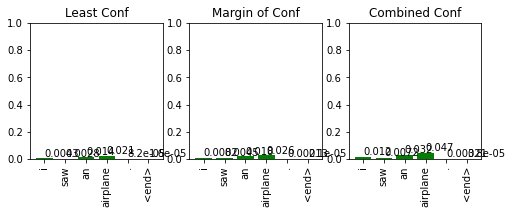


Target:  can i see that ?
Aggregate Sequence Uncertainty: 0.011889052391052247

Input: <start> אני יכולה לראות את זה ? <end>
Predicted translation: can i see that one ? <end> 
Runner-up translation: may we love it ? one ? 


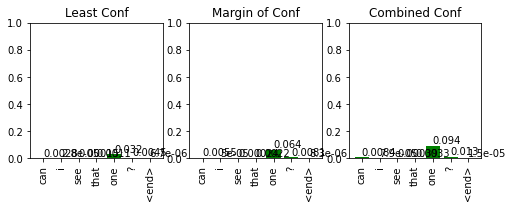


Target:  tom is picky .
Aggregate Sequence Uncertainty: 0.012408572435379028

Input: <start> תום בררן . <end>
Predicted translation: tom is fussy . <end> 
Runner-up translation: tom's will too so tom 


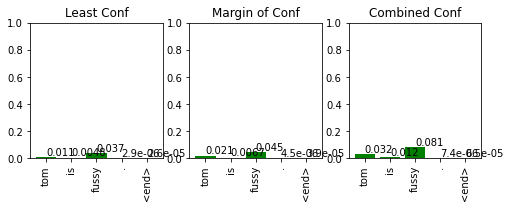


Target:  you must go .
Aggregate Sequence Uncertainty: 0.013505089282989501

Input: <start> אתה חייב ללכת . <end>
Predicted translation: you have to go . <end> 
Runner-up translation: you're must some hurry to me 


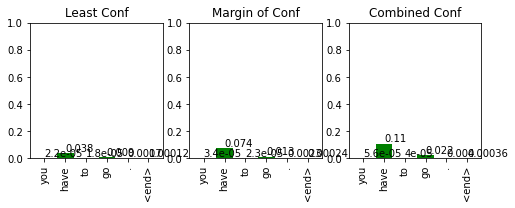


Target:  i've found it .
Aggregate Sequence Uncertainty: 0.015073221921920777

Input: <start> מצאתי את זה . <end>
Predicted translation: i found it . <end> 
Runner-up translation: i've just that out it 


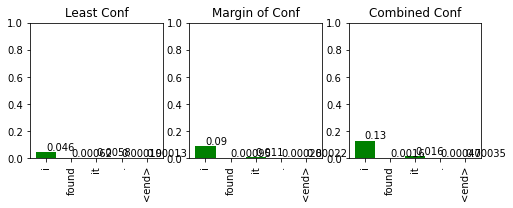


Target:  do as i say .
Aggregate Sequence Uncertainty: 0.015203297138214111

Input: <start> תעשה מה שאני אומר לך . <end>
Predicted translation: do what i say . <end> 
Runner-up translation: look as what care it i 


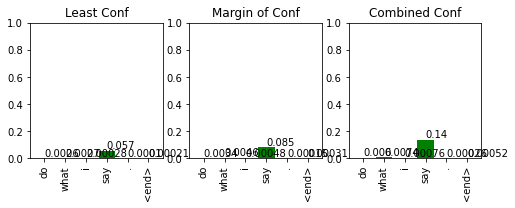


Target:  i dreamed about you .
Aggregate Sequence Uncertainty: 0.015376579761505128

Input: <start> חלמתי עליךָ . <end>
Predicted translation: i dreamt about you . <end> 
Runner-up translation: i'm dreamed to it ! you 


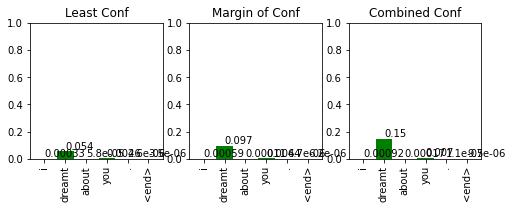


Target:  please have a seat .
Aggregate Sequence Uncertainty: 0.01670820713043213

Input: <start> שבי בבקשה . <end>
Predicted translation: please be seated . <end> 
Runner-up translation: take have merciful ! . 


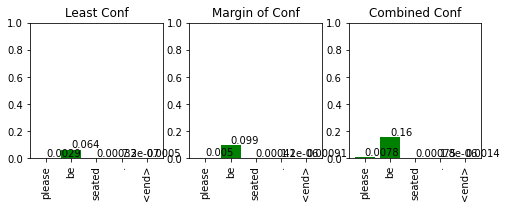


Target:  who hit tom ?
Aggregate Sequence Uncertainty: 0.01708364486694336

Input: <start> מי הרביץ לתום ? <end>
Predicted translation: who beat tom ? <end> 
Runner-up translation: call hit it call him 


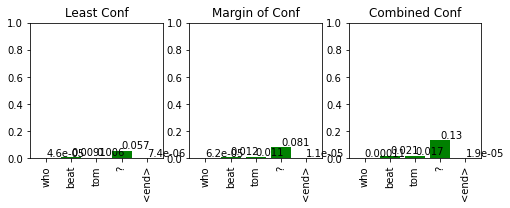


Target:  i'm desperate .
Aggregate Sequence Uncertainty: 0.01935429573059082

Input: <start> אני מיואש . <end>
Predicted translation: i'm discouraged . <end> 
Runner-up translation: i desperate now . 


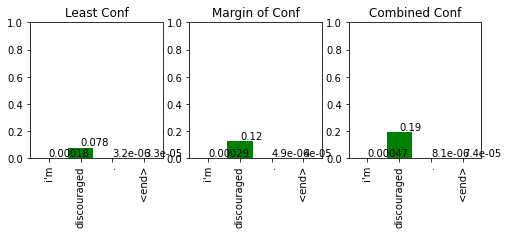

(array([], dtype=float64), array([], dtype=float64))

In [71]:
get_ranked_uncertainty(training_sequences_means, len(non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=non_matches, results=training_results)

OK!  These departures from the overly strict ground truth seem to be decent translations, and would probably qualify as alternate reference translations if we're doing proper accuracy scoring.  That's a good sign, in fact it seems that for our high certainty threshold (which in my run above is just over 63% of the training), we're at 100% accuracy!  Before we get too full of ourselves and forget what we're really after in an Active Learning cycle, let's look at the least confident ones, and along the way try to find some examples of underfitting:




In [86]:
training_unsure_matches, training_unsure_non_matches = get_ranked_uncertainty(training_sequences_means, training_high_uncertainty_sample_size, target_tensor_train,
                                              display=False, results=training_results)
print("Training set non-confident matches: " + str(len(training_unsure_matches)))
print("Training set non-confident non-Matches: " + str(len(training_unsure_non_matches)))

Training set non-confident matches: 0
Training set non-confident non-Matches: 4



Target:  what's your point ?
Aggregate Sequence Uncertainty: 0.31968000958440823

Input: <start> נו , אז מה ? <end>
Predicted translation: what , what about it ? <end> 
Runner-up translation: what's is he , me for i 


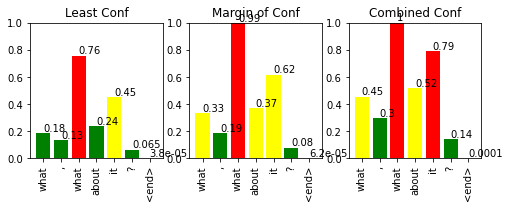


Target:  birds lay eggs .
Aggregate Sequence Uncertainty: 0.275030417740345

Input: <start> עופות מטילים ביצים . <end>
Predicted translation: birds may talk eggs . <end> 
Runner-up translation: the be be . won fuji 


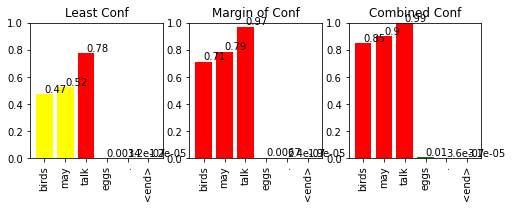


Target:  i was uncomfortable .
Aggregate Sequence Uncertainty: 0.24873623661696911

Input: <start> זה לא היה נוח . <end>
Predicted translation: this was uncomfortable . <end> 
Runner-up translation: it is unhealthy me me 


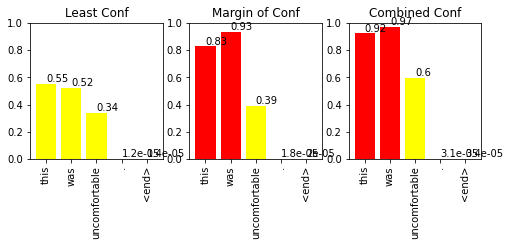


Target:  put your mask on .
Aggregate Sequence Uncertainty: 0.21692604189738632

Input: <start> שים מסיכה . <end>
Predicted translation: keep your mask on . <end> 
Runner-up translation: put off back . me . 


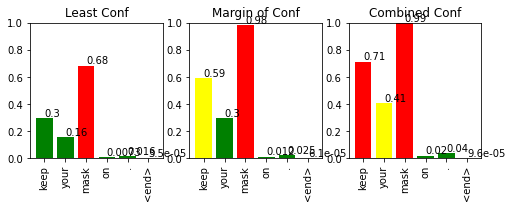

(array([], dtype=float64), array([], dtype=float64))

In [80]:
get_ranked_uncertainty(training_sequences_means, len(training_unsure_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_unsure_non_matches, results=training_results)

Alright, a few issues here among the low certainty cohort.  Not all of these are bad translations in my run e.g. in my set "He's not home" becomes "He isn't at home", or "Let me out!" becomes "I want to leave!"  But let's be hard on ourselves and assume they're all one way or another examples of underfitting - at least finding them by means of low aggregate uncertainty ranking.  Now we're ready to collect some examples for an Active Learning cycle.  Also, playing with the thresholds (and ultimately, optimizing them) would be the next thing to try in future cycles.  But let's move on to the validation set.

### Exploring Variance and (Un)certainty

Previously we saw that the validation results had fewer high confidence examples.  Let's start by looking at those:


In [115]:
val_conf_matches, val_conf_non_matches = get_ranked_uncertainty(val_sequences_means, val_low_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set confident matches: " + str(len(val_conf_matches)))
print("Validation set confident non-matches: " + str(len(val_conf_non_matches)))
print("Matching: {:.1%}".format((len(val_conf_matches)/(len(val_conf_matches)+len(val_conf_non_matches)))))

Validation set confident matches: 171
Validation set confident non-matches: 64
Matching: 72.8%


Right away, we notice that we have fewer overall high-certainty results compared with the training set (using the same threshold as training).  It's also not surprising that we have a higher number of confident non-Matches.  As we did before, let's check out those high certainty non-matches:


Target:  they embraced .
Aggregate Sequence Uncertainty: 0.0001932978630065918

Input: <start> הם התחבקו . <end>
Predicted translation: they hugged . <end> 
Runner-up translation: it all mary mary 


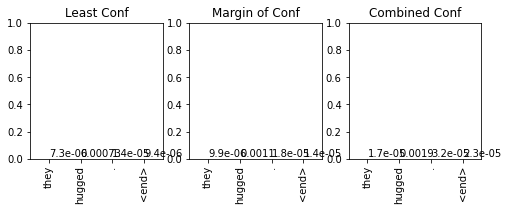


Target:  i feel homesick .
Aggregate Sequence Uncertainty: 0.00043970346450805664

Input: <start> אני מתגעגע הביתה . <end>
Predicted translation: i'm homesick . <end> 
Runner-up translation: i still ? super 


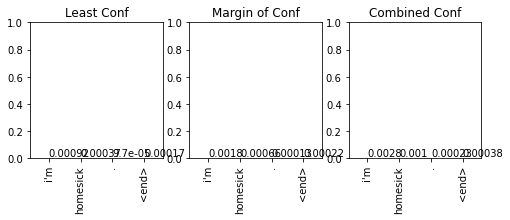


Target:  she idolized him .
Aggregate Sequence Uncertainty: 0.0006267964839935303

Input: <start> היא העריצה אותו . <end>
Predicted translation: she admired him . <end> 
Runner-up translation: i scolded it way him 


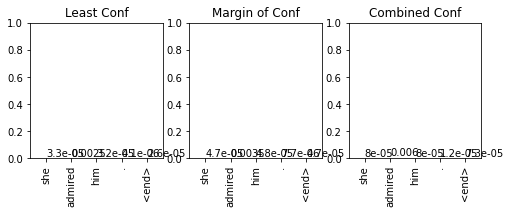


Target:  i knew that .
Aggregate Sequence Uncertainty: 0.001087874174118042

Input: <start> ידעתי זאת . <end>
Predicted translation: i knew it . <end> 
Runner-up translation: you just that all that 


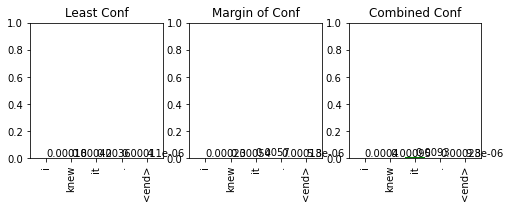


Target:  i often see him .
Aggregate Sequence Uncertainty: 0.0011306703090667725

Input: <start> אני רואה אותו לעתים קרובות . <end>
Predicted translation: i see him . <end> 
Runner-up translation: he can it by mary 


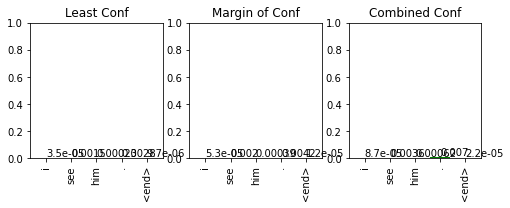


Target:  keep me informed .
Aggregate Sequence Uncertainty: 0.001300680637359619

Input: <start> תמשיך לעדכן אותי . <end>
Predicted translation: keep me advised . <end> 
Runner-up translation: continue advised behind me me 


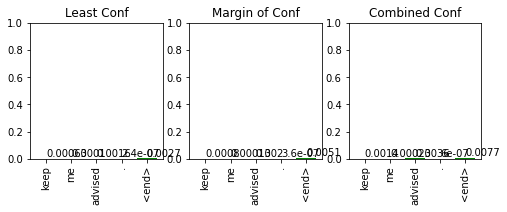


Target:  i want to visit tom .
Aggregate Sequence Uncertainty: 0.0017167508602142334

Input: <start> אני רוצה לבקר את תום . <end>
Predicted translation: i want to see tom . <end> 
Runner-up translation: i've wants see find mary won tom 


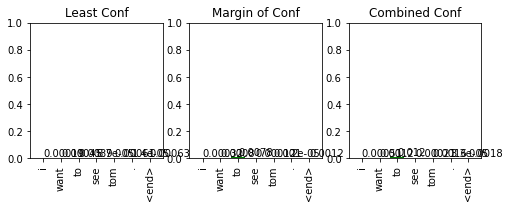


Target:  don't lie to me .
Aggregate Sequence Uncertainty: 0.0017248153686523437

Input: <start> אל תשקרי לי . <end>
Predicted translation: don't tell me . <end> 
Runner-up translation: take talk care see me 


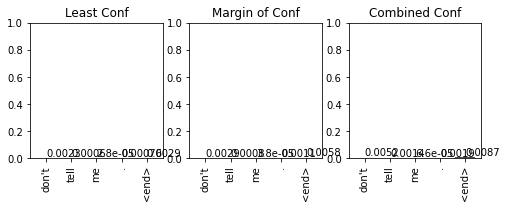


Target:  do you work ?
Aggregate Sequence Uncertainty: 0.0020671844482421874

Input: <start> אתה עובד ? <end>
Predicted translation: are you working ? <end> 
Runner-up translation: do i my working fire 


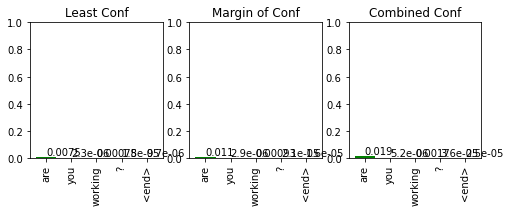


Target:  i oppose it .
Aggregate Sequence Uncertainty: 0.0020727694034576418

Input: <start> אני מניח כך . <end>
Predicted translation: i guess so . <end> 
Runner-up translation: i'm suppose it's so you 


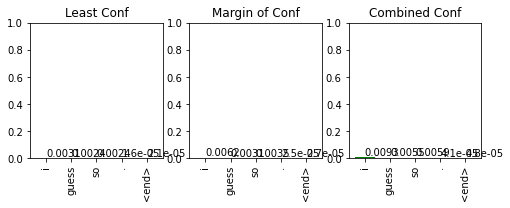


Target:  speak to me .
Aggregate Sequence Uncertainty: 0.0027473092079162596

Input: <start> דבר אלי . <end>
Predicted translation: talk to me . <end> 
Runner-up translation: somebody about cry a . 


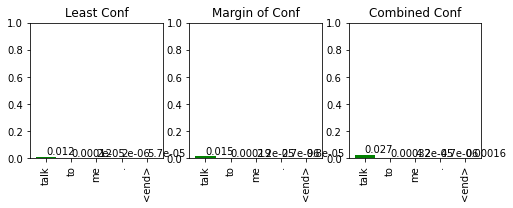


Target:  are you loyal ?
Aggregate Sequence Uncertainty: 0.0027555584907531737

Input: <start> אתה נאמן ? <end>
Predicted translation: are you faithful ? <end> 
Runner-up translation: do we practical retired ? 


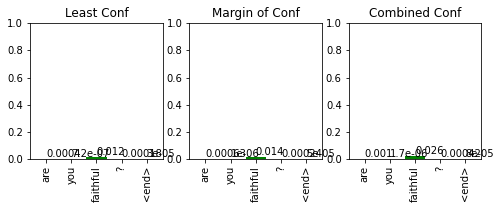


Target:  it was persuasive .
Aggregate Sequence Uncertainty: 0.0034419000148773193

Input: <start> זה היה משכנע . <end>
Predicted translation: it was convincing . <end> 
Runner-up translation: that made persuasive gas me 


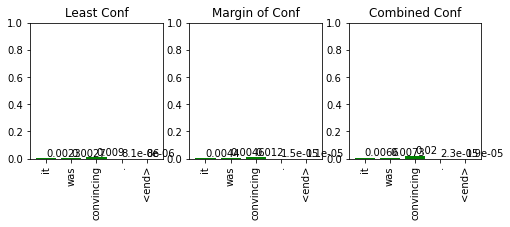


Target:  i'm free .
Aggregate Sequence Uncertainty: 0.0034625053405761717

Input: <start> אני פנוי . <end>
Predicted translation: i'm available . <end> 
Runner-up translation: i free now . 


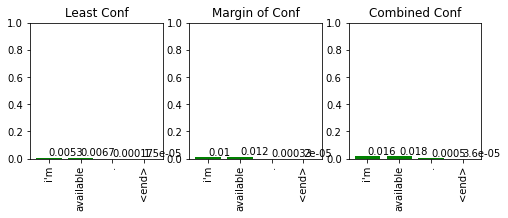


Target:  they're idiots .
Aggregate Sequence Uncertainty: 0.0034766077995300295

Input: <start> הם שוטים . <end>
Predicted translation: they're fools . <end> 
Runner-up translation: they vulgar ! . 


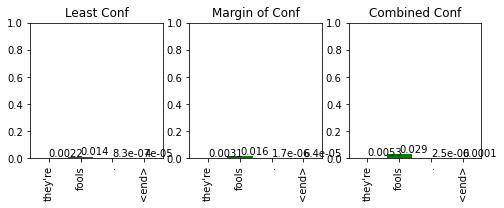


Target:  you're tough .
Aggregate Sequence Uncertainty: 0.0036521732807159426

Input: <start> אתה קשוח . <end>
Predicted translation: you're harsh . <end> 
Runner-up translation: you tough ! fuji 


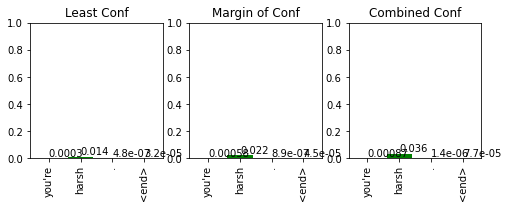


Target:  that's taboo .
Aggregate Sequence Uncertainty: 0.004193180799484253

Input: <start> זה טאבו . <end>
Predicted translation: it's taboo . <end> 
Runner-up translation: that's violent secret . 


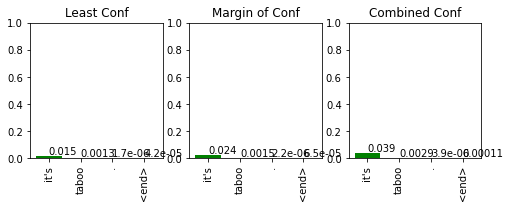


Target:  feed the bird .
Aggregate Sequence Uncertainty: 0.004352140426635742

Input: <start> תן מזון לציפור ! <end>
Predicted translation: feed the bird ! <end> 
Runner-up translation: take a best . that's 


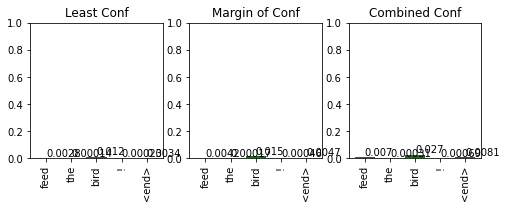


Target:  i painted that .
Aggregate Sequence Uncertainty: 0.004945224523544312

Input: <start> צבעתי את זה . <end>
Predicted translation: i resent that . <end> 
Runner-up translation: i've painted this out it 


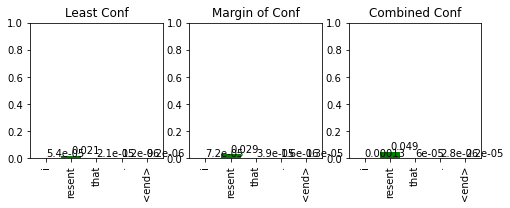


Target:  you are free to go .
Aggregate Sequence Uncertainty: 0.005558806657791138

Input: <start> אתה חופשי ללכת . <end>
Predicted translation: you're free to go . <end> 
Runner-up translation: you there on help now . 


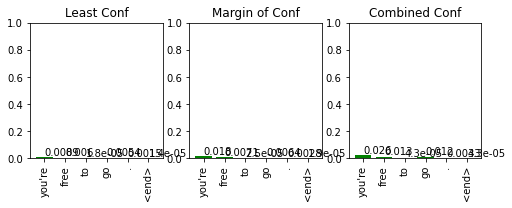


Target:  i'm dead tired .
Aggregate Sequence Uncertainty: 0.005570751428604126

Input: <start> אני מת מעייפות . <end>
Predicted translation: i'm bushed . <end> 
Runner-up translation: it's dying ! me 


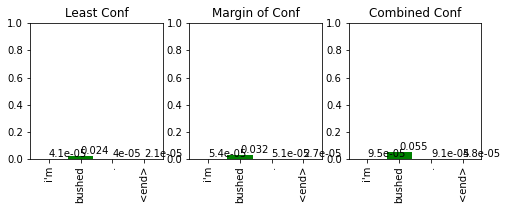


Target:  tom finally left .
Aggregate Sequence Uncertainty: 0.00578199028968811

Input: <start> תום עזב סופסוף . <end>
Predicted translation: tom finally smiled . <end> 
Runner-up translation: tom's left left ! mary 


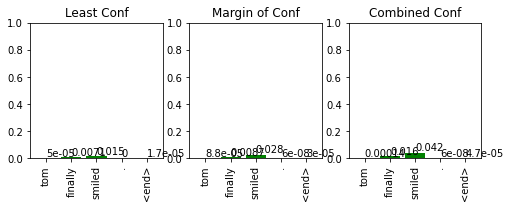


Target:  it will heal .
Aggregate Sequence Uncertainty: 0.00642315149307251

Input: <start> זה יחלים . <end>
Predicted translation: it'll heal . <end> 
Runner-up translation: that'll recover said i 


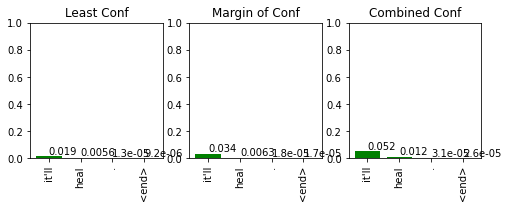


Target:  you look fabulous .
Aggregate Sequence Uncertainty: 0.006438851356506348

Input: <start> את נראית נהדר . <end>
Predicted translation: you look great . <end> 
Runner-up translation: she seem lovely <end> . 


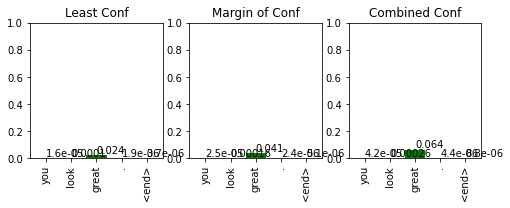


Target:  i'm scared .
Aggregate Sequence Uncertainty: 0.006617844104766846

Input: <start> אני חוששת . <end>
Predicted translation: i'm afraid . <end> 
Runner-up translation: i confused of me 


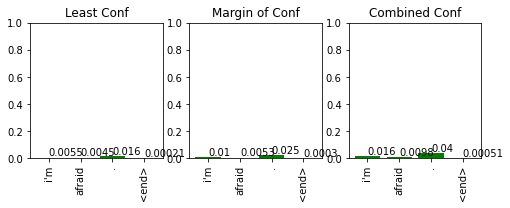


Target:  nobody laughed .
Aggregate Sequence Uncertainty: 0.006648445129394531

Input: <start> אף אחד לא צחק . <end>
Predicted translation: no one laughed . <end> 
Runner-up translation: nobody laughed defeated out him 


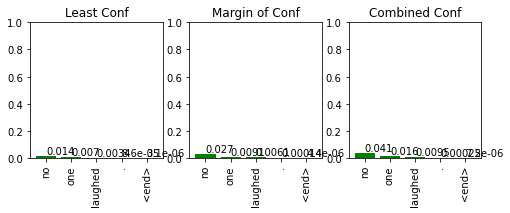


Target:  tom was defeated .
Aggregate Sequence Uncertainty: 0.006865012645721436

Input: <start> תום הובס . <end>
Predicted translation: tom got beat . <end> 
Runner-up translation: they was married it . 


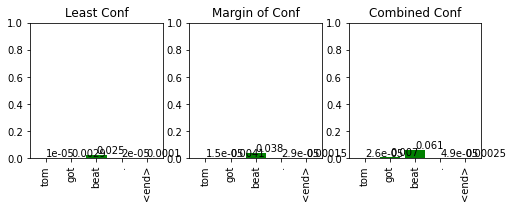


Target:  who is that boy ?
Aggregate Sequence Uncertainty: 0.00797051191329956

Input: <start> מי הנער הזה ? <end>
Predicted translation: who's that boy ? <end> 
Runner-up translation: who this man up fire 


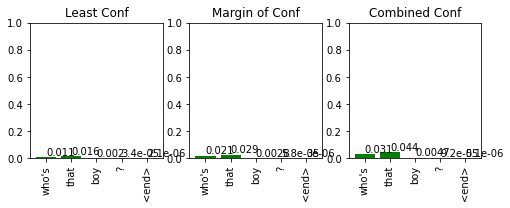


Target:  i'm very happy .
Aggregate Sequence Uncertainty: 0.008242404460906983

Input: <start> אני מאד שמחה . <end>
Predicted translation: i'm so happy . <end> 
Runner-up translation: i very busy here i'm 


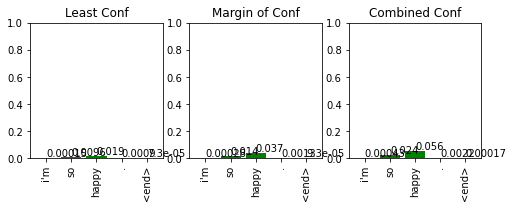


Target:  excuse me .
Aggregate Sequence Uncertainty: 0.00841798186302185

Input: <start> סליחה . <end>
Predicted translation: i'm sorry . <end> 
Runner-up translation: i comfortable i'm myself 


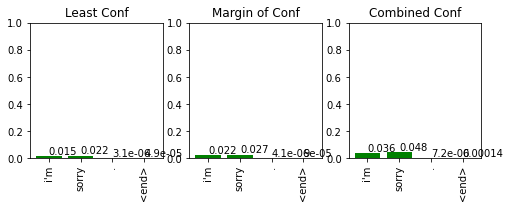


Target:  freeze !
Aggregate Sequence Uncertainty: 0.008610087633132934

Input: <start> אל תזוזו ! <end>
Predicted translation: don't move . <end> 
Runner-up translation: keep be ! ! 


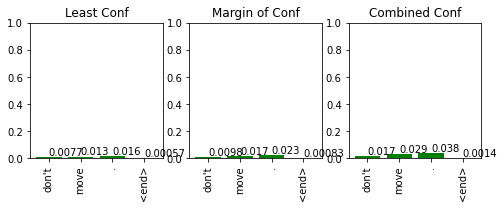


Target:  continue digging .
Aggregate Sequence Uncertainty: 0.008620649576187134

Input: <start> המשיכו לחפור . <end>
Predicted translation: keep digging . <end> 
Runner-up translation: continue practicing ! myself 


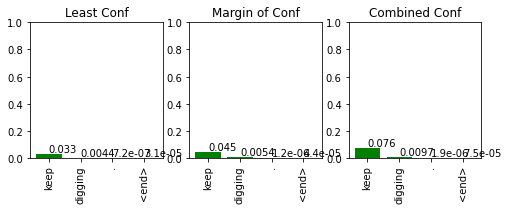


Target:  tom relented .
Aggregate Sequence Uncertainty: 0.008621567487716674

Input: <start> תום ויתר . <end>
Predicted translation: tom gave in . <end> 
Runner-up translation: tom's let a tom . 


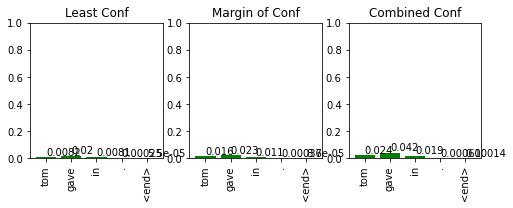


Target:  he did it himself .
Aggregate Sequence Uncertainty: 0.008837312459945679

Input: <start> הוא עשה זאת לבד . <end>
Predicted translation: he did it alone . <end> 
Runner-up translation: if made do by it i 


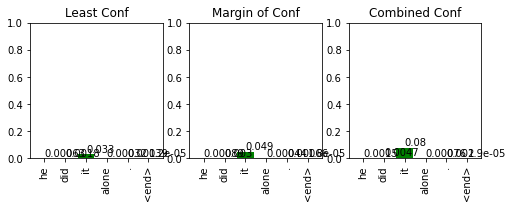


Target:  are you guys free ?
Aggregate Sequence Uncertainty: 0.008888393640518188

Input: <start> אתם חופשיים ? <end>
Predicted translation: are you free ? <end> 
Runner-up translation: do they guys free mary 


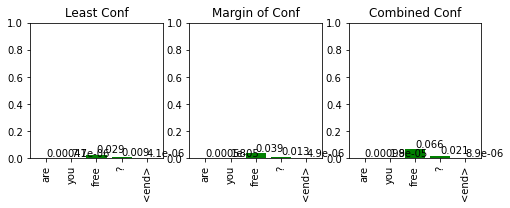


Target:  we like him .
Aggregate Sequence Uncertainty: 0.00912303924560547

Input: <start> אנו אוהבים אותו . <end>
Predicted translation: we love him . <end> 
Runner-up translation: they like with on him 


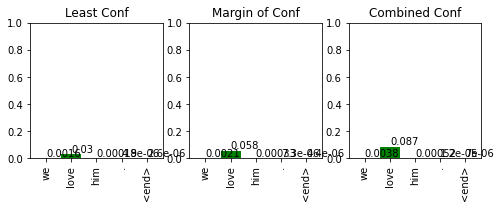


Target:  ignore that .
Aggregate Sequence Uncertainty: 0.009597563743591308

Input: <start> להתעלם מזה . <end>
Predicted translation: skip it . <end> 
Runner-up translation: ignore him was . 


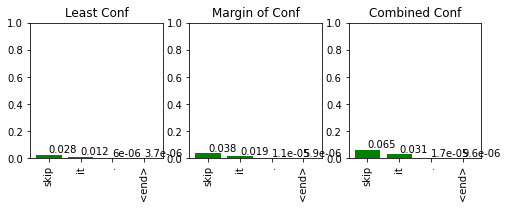


Target:  this is remarkable .
Aggregate Sequence Uncertainty: 0.00999842882156372

Input: <start> זה יוצא מן הכלל . <end>
Predicted translation: that's remarkable . <end> 
Runner-up translation: this outstanding is . 


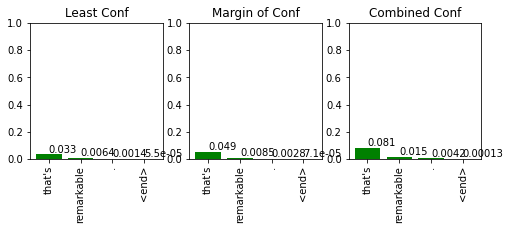


Target:  tom hailed a cab .
Aggregate Sequence Uncertainty: 0.010243147611618042

Input: <start> תום עצר מונית . <end>
Predicted translation: tom stopped talking . <end> 
Runner-up translation: tom's likes to ? . 


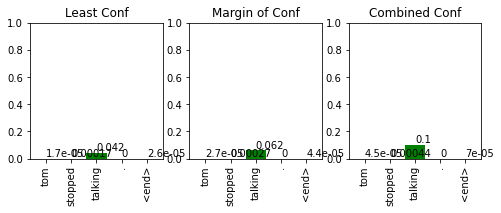


Target:  watch us .
Aggregate Sequence Uncertainty: 0.010361486673355102

Input: <start> הביטו בנו . <end>
Predicted translation: watch yourselves . <end> 
Runner-up translation: keep to us us 


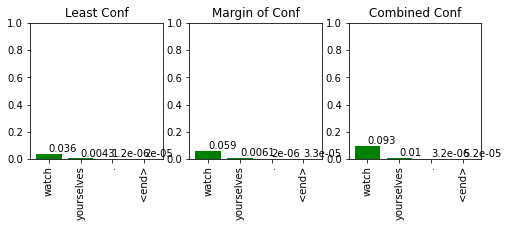


Target:  tom is overworked .
Aggregate Sequence Uncertainty: 0.010623228549957276

Input: <start> תום עובד קשה מדי . <end>
Predicted translation: tom works too hard . <end> 
Runner-up translation: tom's is hard bright ! . 


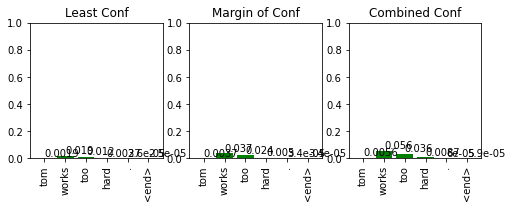


Target:  tom was baffled .
Aggregate Sequence Uncertainty: 0.010828322172164917

Input: <start> תום היה מופתע . <end>
Predicted translation: tom was surprised . <end> 
Runner-up translation: they got puzzled me tom 


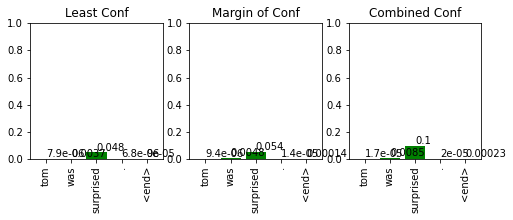


Target:  i made this for you .
Aggregate Sequence Uncertainty: 0.011409294605255128

Input: <start> עשיתי זאת למענך . <end>
Predicted translation: i did it for you . <end> 
Runner-up translation: you made about to it to i 


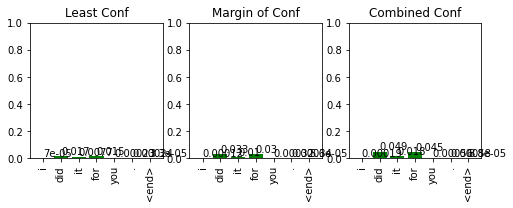


Target:  i'm in charge here .
Aggregate Sequence Uncertainty: 0.011804598569869994

Input: <start> אני הממונה כאן . <end>
Predicted translation: i am in charge here . <end> 
Runner-up translation: i'm are taller here . is . 


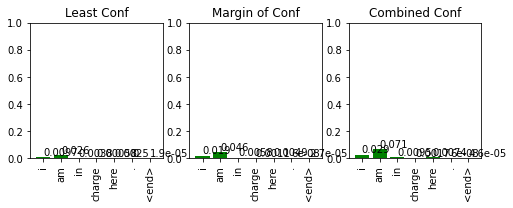


Target:  tom cringed .
Aggregate Sequence Uncertainty: 0.012149816751480103

Input: <start> תום נרתע . <end>
Predicted translation: tom flinched . <end> 
Runner-up translation: tom's reacted by mary 


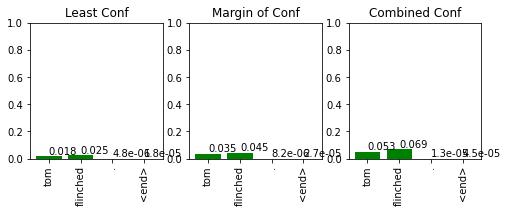


Target:  it was pathetic .
Aggregate Sequence Uncertainty: 0.012215507030487061

Input: <start> זה היה מעורר רחמים . <end>
Predicted translation: that was pathetic . <end> 
Runner-up translation: it turned remarkable it . 


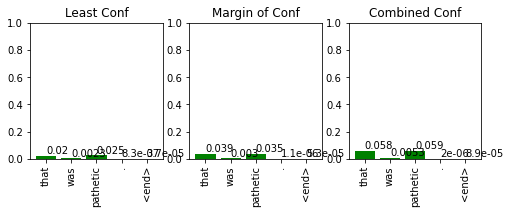


Target:  you caught me .
Aggregate Sequence Uncertainty: 0.012222838401794434

Input: <start> תפסת אותי . <end>
Predicted translation: you got me . <end> 
Runner-up translation: she have fired out me 


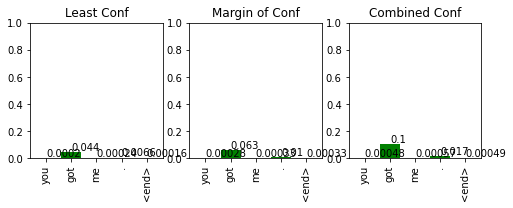


Target:  did you see anybody ?
Aggregate Sequence Uncertainty: 0.012297475337982177

Input: <start> האם ראית מישהו ? <end>
Predicted translation: did you see anyone ? <end> 
Runner-up translation: anybody anyone call anybody anybody me 


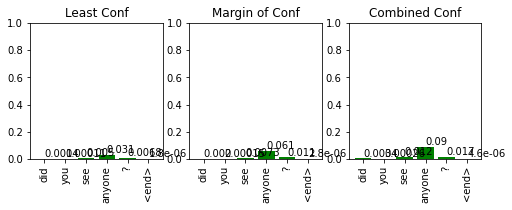


Target:  tom grinned .
Aggregate Sequence Uncertainty: 0.01293647289276123

Input: <start> תום חייך . <end>
Predicted translation: tom was smiling . <end> 
Runner-up translation: tom's smiled screaming ! mary 


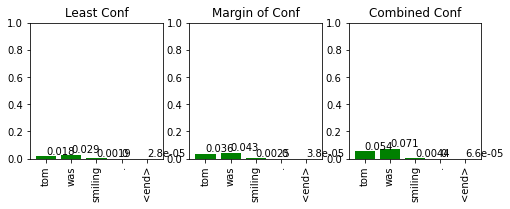


Target:  shall we begin ?
Aggregate Sequence Uncertainty: 0.013860303163528442

Input: <start> נתחיל ? <end>
Predicted translation: shall we start ? <end> 
Runner-up translation: who'll we're dance we how 


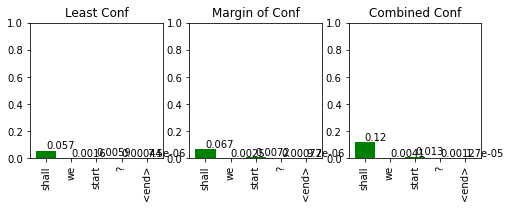


Target:  it was just a dream .
Aggregate Sequence Uncertainty: 0.013986545801162719

Input: <start> זה היה רק חלום . <end>
Predicted translation: it was only a dream . <end> 
Runner-up translation: it's just a simple wish to me 


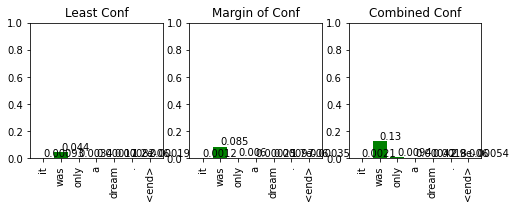


Target:  come over !
Aggregate Sequence Uncertainty: 0.014790153503417969

Input: <start> בואי הנה . <end>
Predicted translation: come over . <end> 
Runner-up translation: get here here . 


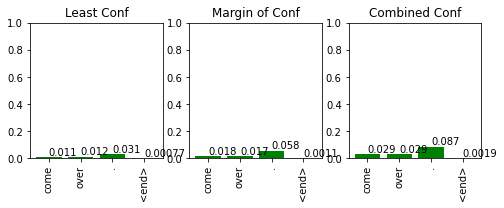


Target:  that's plenty .
Aggregate Sequence Uncertainty: 0.014852941036224365

Input: <start> זה די והותר . <end>
Predicted translation: that's quite a bit . <end> 
Runner-up translation: it's pretty to dream shy . 


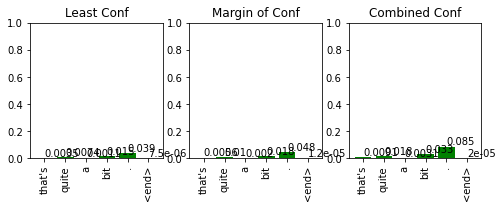


Target:  these are my books .
Aggregate Sequence Uncertainty: 0.014954161643981934

Input: <start> אלו ספריי . <end>
Predicted translation: those are my books . <end> 
Runner-up translation: everybody my in wine a . 


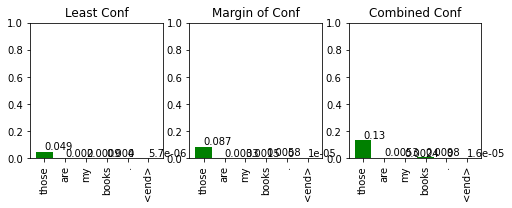


Target:  we already ate .
Aggregate Sequence Uncertainty: 0.015336704254150391

Input: <start> כבר אכלנו . <end>
Predicted translation: we've eaten . <end> 
Runner-up translation: we had to . 


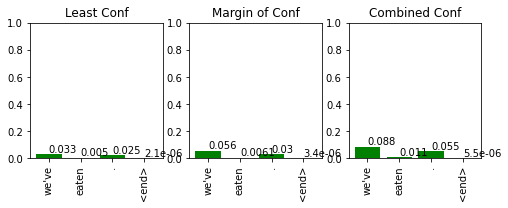


Target:  everybody danced .
Aggregate Sequence Uncertainty: 0.015730082988739014

Input: <start> כולם רקדו . <end>
Predicted translation: everyone danced . <end> 
Runner-up translation: everybody is <end> . 


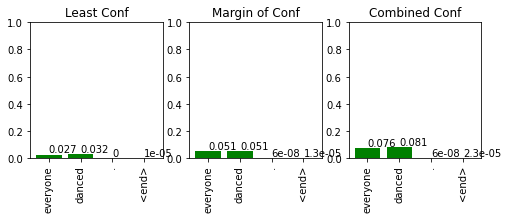


Target:  you may sit down .
Aggregate Sequence Uncertainty: 0.015918046236038208

Input: <start> את מוזמנת להתיישב . <end>
Predicted translation: you may sit . <end> 
Runner-up translation: you're might be up you 


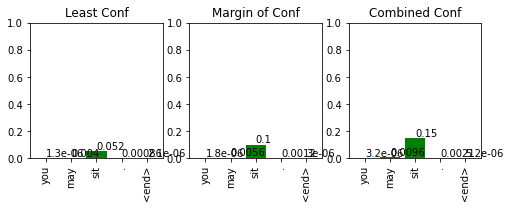


Target:  be merciless .
Aggregate Sequence Uncertainty: 0.01630769968032837

Input: <start> היו חסרי רחמים . <end>
Predicted translation: be ruthless . <end> 
Runner-up translation: love merciless ! . 


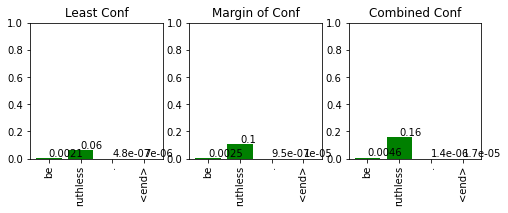


Target:  tom got cheated .
Aggregate Sequence Uncertainty: 0.01645588278770447

Input: <start> רימו את תום . <end>
Predicted translation: tom was cheated . <end> 
Runner-up translation: they cheated cheating it tom 


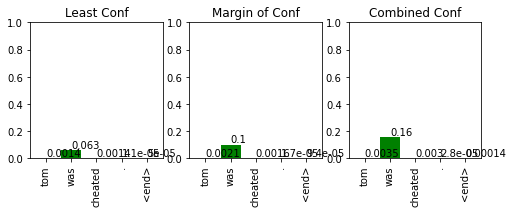


Target:  tom has hay fever .
Aggregate Sequence Uncertainty: 0.017217081785202027

Input: <start> לתום יש קדחת השחת . <end>
Predicted translation: tom has three cats . <end> 
Runner-up translation: tom's three hay pens off fuji 


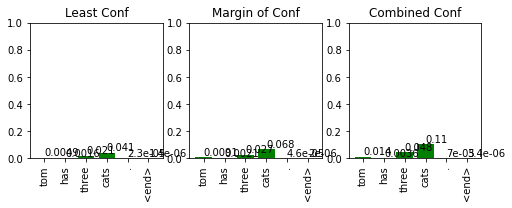


Target:  it's a possibility .
Aggregate Sequence Uncertainty: 0.017936939001083375

Input: <start> זאת אפשרות . <end>
Predicted translation: it is an option . <end> 
Runner-up translation: it's will a indian time . 


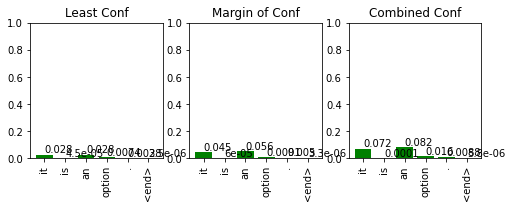


Target:  tom is blushing .
Aggregate Sequence Uncertainty: 0.01834460496902466

Input: <start> תום מסמיק . <end>
Predicted translation: tom is turning red . <end> 
Runner-up translation: tom's stutters red . red mary 


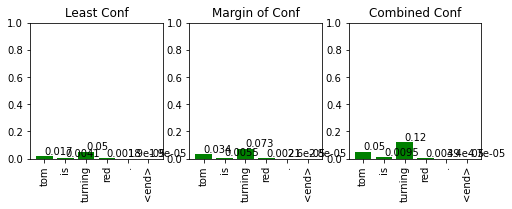


Target:  pick that up .
Aggregate Sequence Uncertainty: 0.01881689429283142

Input: <start> תרים את זה . <end>
Predicted translation: lift it up . <end> 
Runner-up translation: pick this to to that 


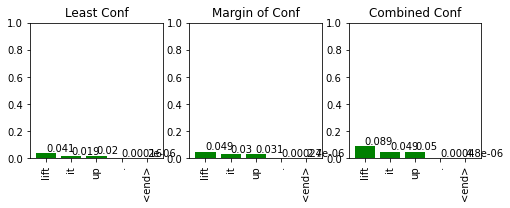


Target:  i will be back soon .
Aggregate Sequence Uncertainty: 0.019048917293548583

Input: <start> מיד אשוב . <end>
Predicted translation: i'll be back soon . <end> 
Runner-up translation: i return right back back . 


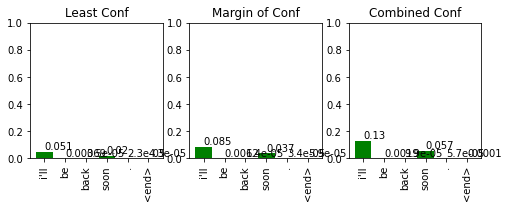

(array([], dtype=float64), array([], dtype=float64))

In [83]:
get_ranked_uncertainty(val_sequences_means, len(val_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_non_matches, results=val_results)

The majority of these are decent alternate translations, and again uncovers issues where MT result is better than the "ground truth" e.g. in my set the translation "i'm here" is better than "I'm in here". Let's look at the much larger least confident cohort:

In [112]:
val_unsure_matches, val_unsure_non_matches = get_ranked_uncertainty(val_sequences_means, val_high_uncertainty_sample_size, target_tensor_val,
                                              display=False, results=val_results)
print("Validation set non-confident matches: " + str(len(val_unsure_matches)))
print("Validation set non-confident non-Matches: " + str(len(val_unsure_non_matches)))
print("Matching: {:.1%}".format(len(val_unsure_matches)/(len(val_unsure_matches)+len(val_unsure_non_matches))))

Validation set non-confident matches: 5
Validation set non-confident non-Matches: 79
Matching: 6.0%



Target:  how can i see you ?
Aggregate Sequence Uncertainty: 0.45256608529016373

Input: <start> איך אוכל לראות אותך ? <end>
Predicted translation: how do i see i see i ? <end> 
Runner-up translation: what may we eat you ? you see i 


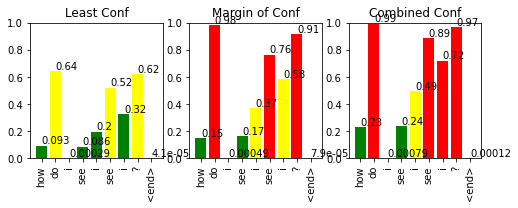


Target:  a fox came along .
Aggregate Sequence Uncertainty: 0.3705626239301637

Input: <start> שועל הופיע . <end>
Predicted translation: a revolt rang by . <end> 
Runner-up translation: i whale are . sight fuji 


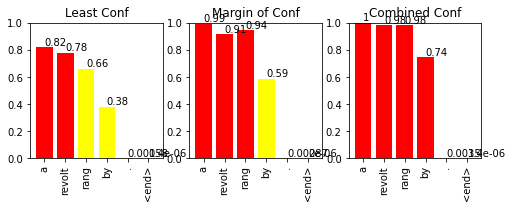


Target:  stop poking me .
Aggregate Sequence Uncertainty: 0.3677449441049248

Input: <start> תפסיק לעשות לי פוקינג . <end>
Predicted translation: let do as i rest . <end> 
Runner-up translation: stop should do his second a i 


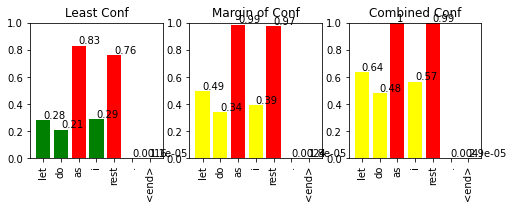


Target:  time is on my side .
Aggregate Sequence Uncertainty: 0.3637594818137586

Input: <start> הזמן הוא לטובתי . <end>
Predicted translation: my hands on . <end> 
Runner-up translation: time husband . a . 


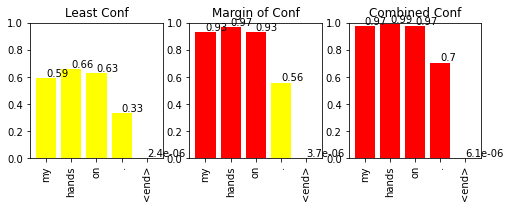


Target:  did i wake you guys ?
Aggregate Sequence Uncertainty: 0.36236241906881334

Input: <start> הערתי אתכם , חברה ? <end>
Predicted translation: did you guys took a tip ? <end> 
Runner-up translation: anybody i hit you ? lot . fuji 


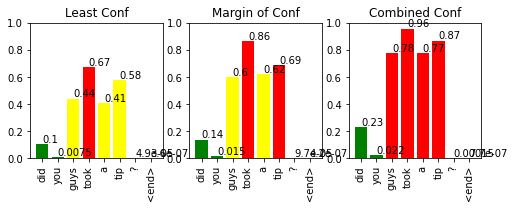


Target:  it did not come off .
Aggregate Sequence Uncertainty: 0.358007469214499

Input: <start> זה לא עלה יפה . <end>
Predicted translation: it won't cost a while . <end> 
Runner-up translation: that did go fun mess ! me 


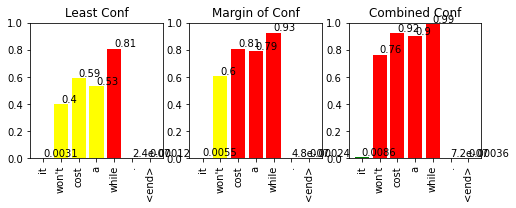


Target:  is it my turn ?
Aggregate Sequence Uncertainty: 0.35091991666704414

Input: <start> האם זה התור שלי ? <end>
Predicted translation: is it is it true ? <end> 
Runner-up translation: was that my yours on now fire 


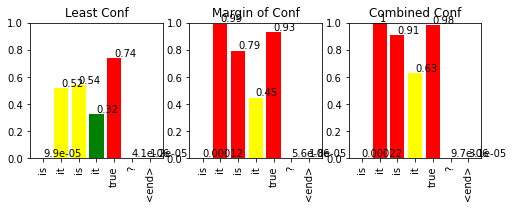


Target:  trust in god .
Aggregate Sequence Uncertainty: 0.3320029477588832

Input: <start> שים את מבטחך באל . <end>
Predicted translation: leave in his back . <end> 
Runner-up translation: throw it our step on . 


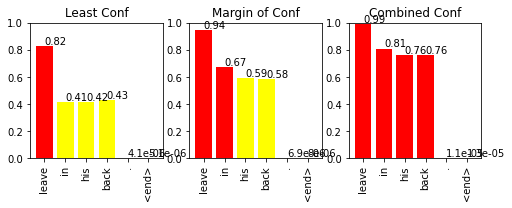


Target:  life passed him by .
Aggregate Sequence Uncertainty: 0.3035161029547453

Input: <start> החיים פסחו עליו . <end>
Predicted translation: every bed is dinner . <end> 
Runner-up translation: ok fish . him on him 


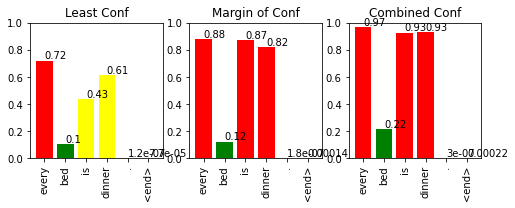


Target:  i was just relaxing .
Aggregate Sequence Uncertainty: 0.3022854160517454

Input: <start> סתם התרגעתי . <end>
Predicted translation: just be just hurt . <end> 
Runner-up translation: i just polite relax it you 


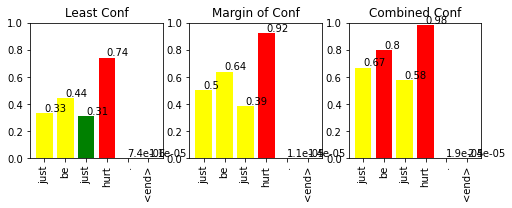


Target:  get to class .
Aggregate Sequence Uncertainty: 0.2992896089330316

Input: <start> גש לכיתה . <end>
Predicted translation: stay to my office . <end> 
Runner-up translation: get at the house is i 


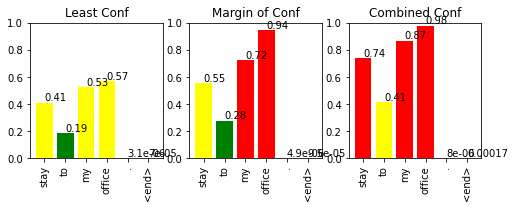


Target:  i miss my cat .
Aggregate Sequence Uncertainty: 0.2967298701405525

Input: <start> חתולי חסר לי . <end>
Predicted translation: i missed my place . <end> 
Runner-up translation: i'm lack a mind ! . 


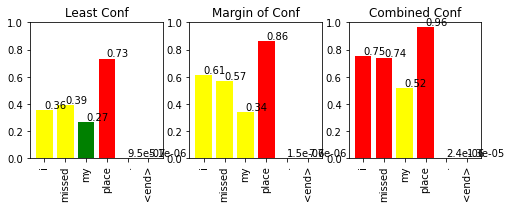


Target:  it's a bad time .
Aggregate Sequence Uncertainty: 0.29598794020712377

Input: <start> זה זמן לא טוב . <end>
Predicted translation: it's time is fun . <end> 
Runner-up translation: that's no . bad to me 


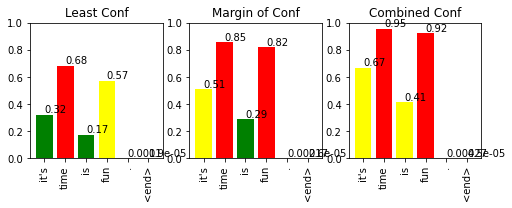


Target:  that would follow .
Aggregate Sequence Uncertainty: 0.2935965247452259

Input: <start> זה הבא בתור . <end>
Predicted translation: that's what for time . <end> 
Runner-up translation: this for it you is . 


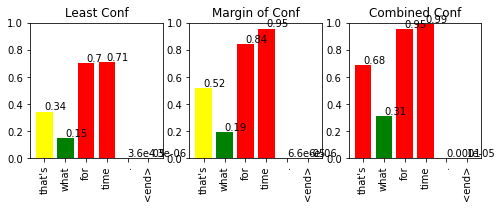


Target:  listen , all of you .
Aggregate Sequence Uncertainty: 0.2920158449560404

Input: <start> הקשיבו , כולכם . <end>
Predicted translation: you have all all . <end> 
Runner-up translation: i've got a of you you 


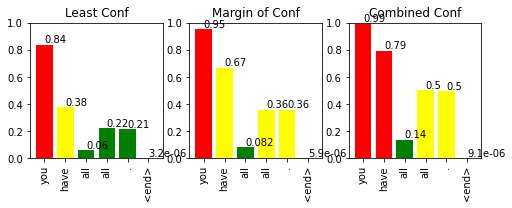


Target:  you're back .
Aggregate Sequence Uncertainty: 0.2910784549312666

Input: <start> חזרתם . <end>
Predicted translation: we were drugged . <end> 
Runner-up translation: you got waiting ! super 


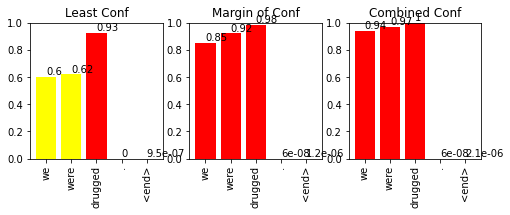


Target:  i checked the gauge .
Aggregate Sequence Uncertainty: 0.28703273441642524

Input: <start> בדקתי את המד . <end>
Predicted translation: i gritted the colors . <end> 
Runner-up translation: i'm checked myself gauge myself myself 


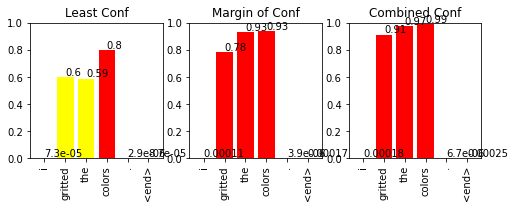


Target:  you take care now .
Aggregate Sequence Uncertainty: 0.28588696755468845

Input: <start> תשמור על עצמך . <end>
Predicted translation: you will be back . <end> 
Runner-up translation: be keep have seated down yourself 


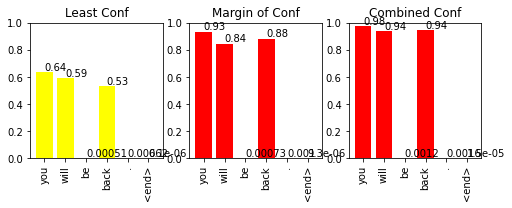


Target:  don't move , please .
Aggregate Sequence Uncertainty: 0.2839264079928398

Input: <start> אל תזוזי בבקשה . <end>
Predicted translation: please step back . <end> 
Runner-up translation: don't be inside now . 


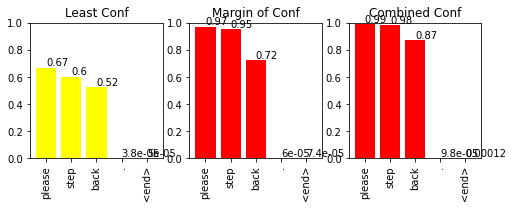


Target:  he had ambition .
Aggregate Sequence Uncertainty: 0.2796334496932104

Input: <start> הוא היה שאפתני . <end>
Predicted translation: he was looking down . <end> 
Runner-up translation: he's became surviving . ! . 


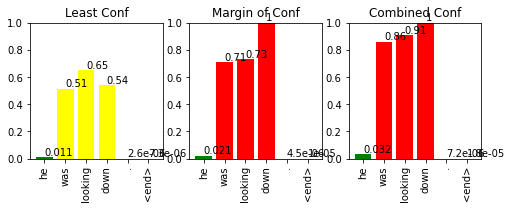


Target:  i brought a book .
Aggregate Sequence Uncertainty: 0.278407184779644

Input: <start> הבאתי איתי ספר . <end>
Predicted translation: i got to read a hug . <end> 
Runner-up translation: i've brought me school . book a me 


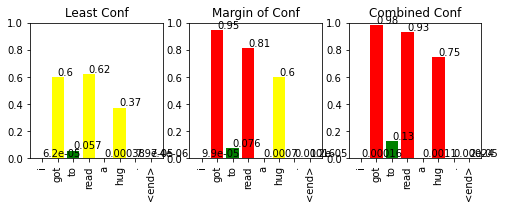


Target:  why didn't you ask ?
Aggregate Sequence Uncertainty: 0.276581533998251

Input: <start> למה לא שאלת ? <end>
Predicted translation: why not i laugh ? <end> 
Runner-up translation: what didn't even care in i 


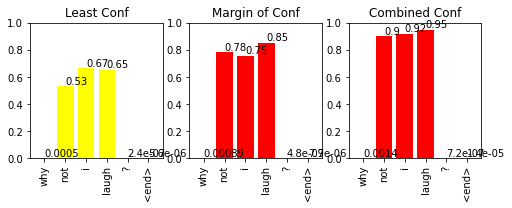


Target:  i admit my mistake .
Aggregate Sequence Uncertainty: 0.27634416036307813

Input: <start> אני מודה בטעות . <end>
Predicted translation: i plead not my job . <end> 
Runner-up translation: i'm admit my portugal service me i 


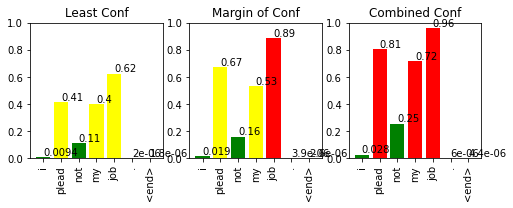


Target:  the news upset me .
Aggregate Sequence Uncertainty: 0.2762899283319712

Input: <start> החדשות העכירו את רוחי . <end>
Predicted translation: my coffee upset me . <end> 
Runner-up translation: a real rang bread gas me 


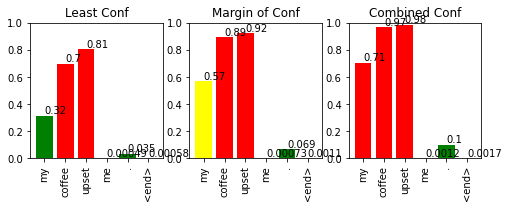


Target:  this isn't love .
Aggregate Sequence Uncertainty: 0.2740712083876133

Input: <start> זאת לא אהבה . <end>
Predicted translation: this is not love . <end> 
Runner-up translation: it's isn't love like stories i 


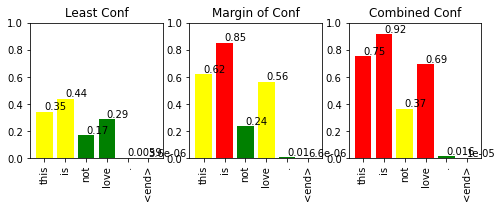


Target:  we sang for her .
Aggregate Sequence Uncertainty: 0.2738502038177103

Input: <start> שרנו לה . <end>
Predicted translation: i was teaching . <end> 
Runner-up translation: you lucked her him i 


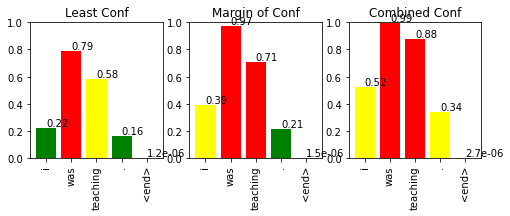


Target:  i hate taking risks .
Aggregate Sequence Uncertainty: 0.27194283716380596

Input: <start> אני שונא סיכון . <end>
Predicted translation: i hate taking a pattern . <end> 
Runner-up translation: i'm have fighting risks stroke on . 


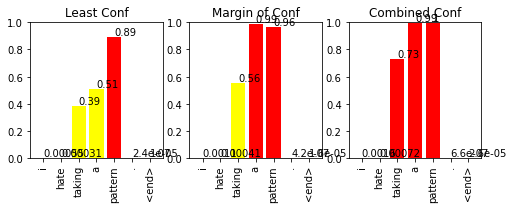


Target:  isn't that your job ?
Aggregate Sequence Uncertainty: 0.27089448934420945

Input: <start> זה לא התפקיד שלך ? <end>
Predicted translation: isn't it your job ? <end> 
Runner-up translation: is that all role it me 


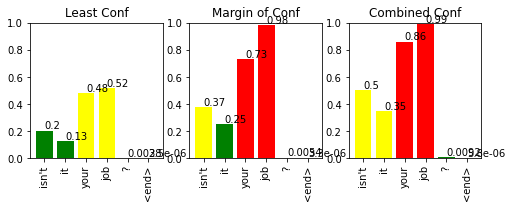


Target:  i said maybe .
Aggregate Sequence Uncertainty: 0.2699939202517271

Input: <start> אמרתי אולי . <end>
Predicted translation: i said it's coming . <end> 
Runner-up translation: i'm can't tall true could i 


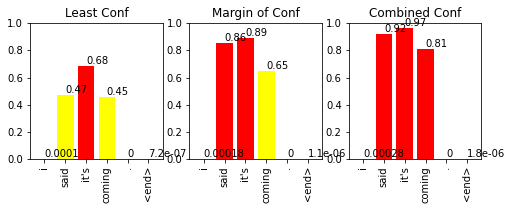


Target:  call me right back .
Aggregate Sequence Uncertainty: 0.26867088563740255

Input: <start> צלצל אלי מיד בחזרה . <end>
Predicted translation: call me back at back . <end> 
Runner-up translation: leave my right soon eight at i 


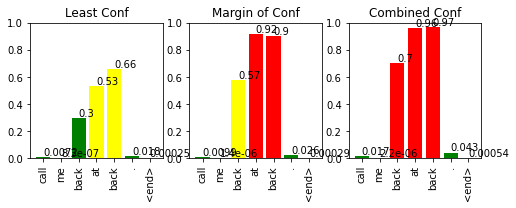


Target:  what's the reason ?
Aggregate Sequence Uncertainty: 0.2678890920476988

Input: <start> מה הסיבה ? <end>
Predicted translation: what do you do ? <end> 
Runner-up translation: anything are i don't you ? 


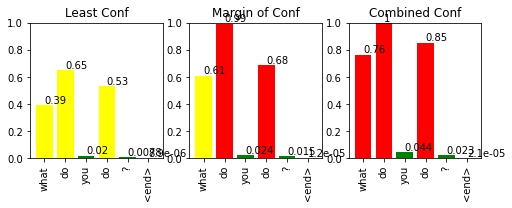


Target:  i must look a sight .
Aggregate Sequence Uncertainty: 0.2664550507441163

Input: <start> אני בוודאי נראית נורא ואיום . <end>
Predicted translation: i must look a awful . <end> 
Runner-up translation: i'm may be nice cold life . 


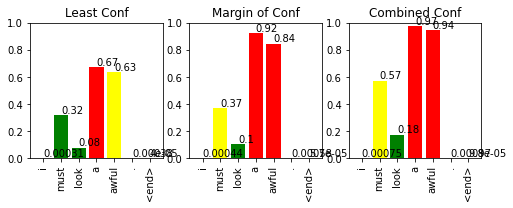


Target:  lead is a metal .
Aggregate Sequence Uncertainty: 0.2663300809537759

Input: <start> עופרת היא מתכת . <end>
Predicted translation: lead is a mistake . <end> 
Runner-up translation: i it an man ! i 


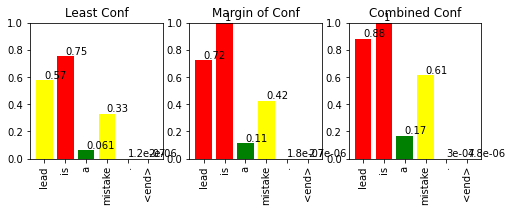


Target:  italy isn't greece .
Aggregate Sequence Uncertainty: 0.2610718398820609

Input: <start> איטליה אינה יוון . <end>
Predicted translation: italy is less . <end> 
Runner-up translation: no isn't unrealistic egg fuji 


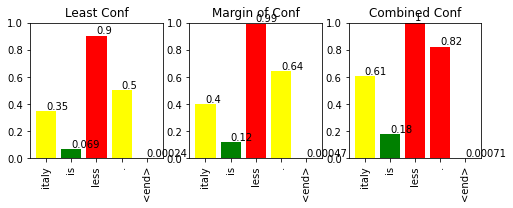


Target:  he was born in 1960 .
Aggregate Sequence Uncertainty: 0.2538105996325612

Input: <start> הוא יליד 1960 . <end>
Predicted translation: he was at marks . <end> 
Runner-up translation: tom is born seven marks fuji 


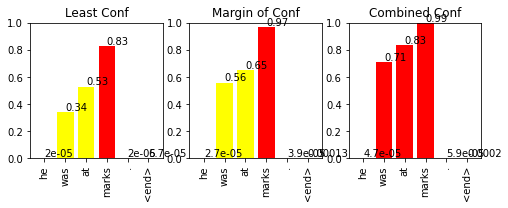


Target:  tom , is that you ?
Aggregate Sequence Uncertainty: 0.25214133895933627

Input: <start> תום , זה אתה ? <end>
Predicted translation: tom , do you know ? <end> 
Runner-up translation: has it it it it that mary 


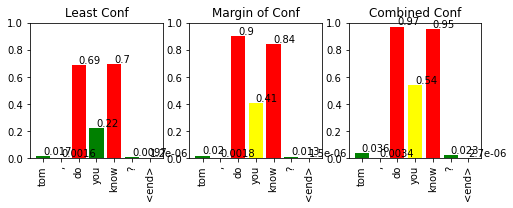


Target:  it uses solar power .
Aggregate Sequence Uncertainty: 0.251923778001219

Input: <start> זה משתמש באנרגיה סולרית . <end>
Predicted translation: it protect her teeth . <end> 
Runner-up translation: that fits me gum ! fuji 


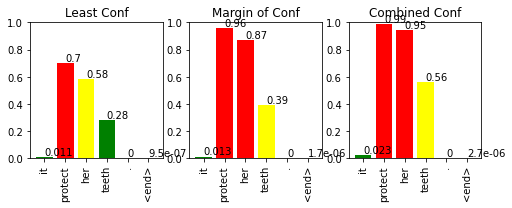


Target:  now let go .
Aggregate Sequence Uncertainty: 0.24832442563492804

Input: <start> עכשיו הרפה . <end>
Predicted translation: now is your move . <end> 
Runner-up translation: now's be seven turn now . 


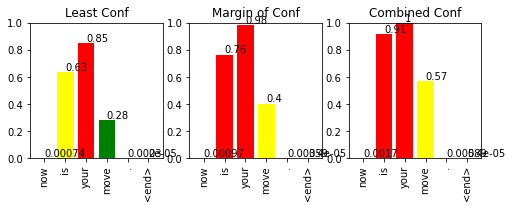


Target:  his room is untidy .
Aggregate Sequence Uncertainty: 0.24684617556631566

Input: <start> חדרו מבולגן . <end>
Predicted translation: his head is untidy . <end> 
Runner-up translation: the room blew a off . 


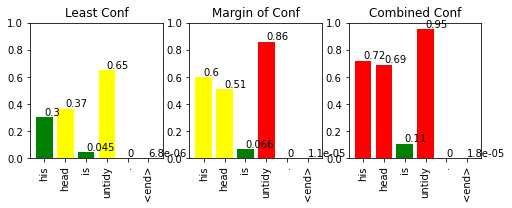


Target:  he is walking now .
Aggregate Sequence Uncertainty: 0.24666173607110978

Input: <start> הוא הולך עכשיו . <end>
Predicted translation: he is now . <end> 
Runner-up translation: he's walks resting i i 


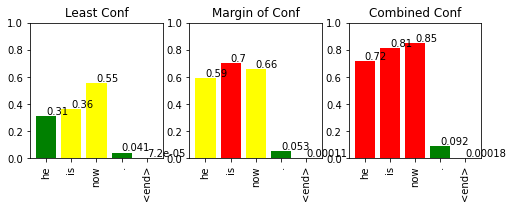


Target:  it's inadequate .
Aggregate Sequence Uncertainty: 0.24634843656094746

Input: <start> זה לא מספק . <end>
Predicted translation: it's not crowded . <end> 
Runner-up translation: that's private complex ! fuji 


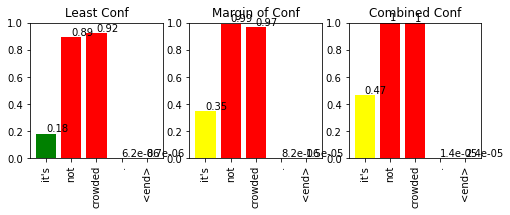


Target:  what's up ?
Aggregate Sequence Uncertainty: 0.24391201436519622

Input: <start> מה המצב ? <end>
Predicted translation: what are you ? <end> 
Runner-up translation: what's is those doing ? 


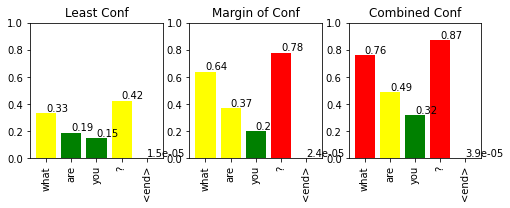


Target:  it's on fire .
Aggregate Sequence Uncertainty: 0.24245701683685184

Input: <start> זה עולה באש . <end>
Predicted translation: that place twice . <end> 
Runner-up translation: it is shut sunday fuji 


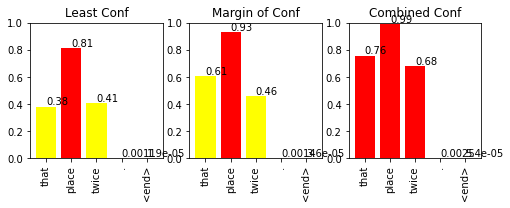


Target:  this is fabulous .
Aggregate Sequence Uncertainty: 0.24053236045874654

Input: <start> זה אגדתי . <end>
Predicted translation: it's a fruit . <end> 
Runner-up translation: this getting relief is . 


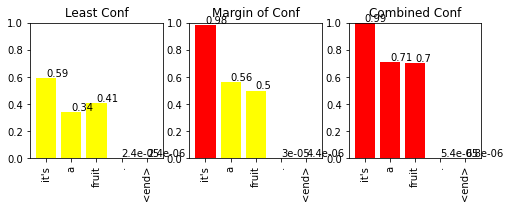


Target:  whatever you say .
Aggregate Sequence Uncertainty: 0.24045136347413062

Input: <start> מה שתגידו . <end>
Predicted translation: i'll be wrong . <end> 
Runner-up translation: don't say say now you 


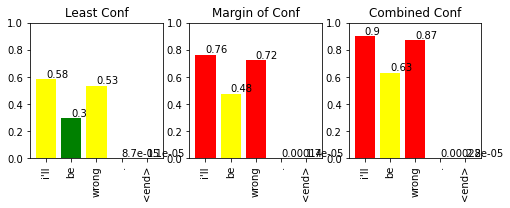


Target:  bear with me .
Aggregate Sequence Uncertainty: 0.23954436057247222

Input: <start> אבקש את סבלנותך . <end>
Predicted translation: dad called me . <end> 
Runner-up translation: a coat i gas me 


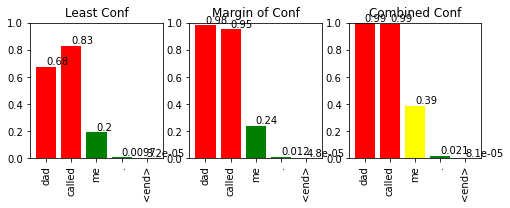


Target:  i broke a nail .
Aggregate Sequence Uncertainty: 0.23695274922065437

Input: <start> שברתי ציפורן . <end>
Predicted translation: i broke my theory . <end> 
Runner-up translation: my fractured a identity off . 


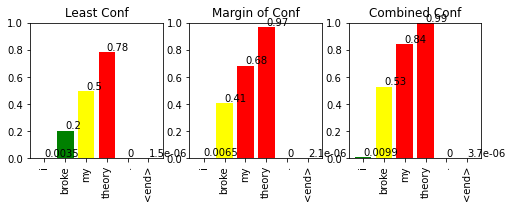


Target:  we did well today .
Aggregate Sequence Uncertainty: 0.23567820824682711

Input: <start> הצלחנו היטב היום . <end>
Predicted translation: mary can buy today . <end> 
Runner-up translation: we is dance well today fuji 


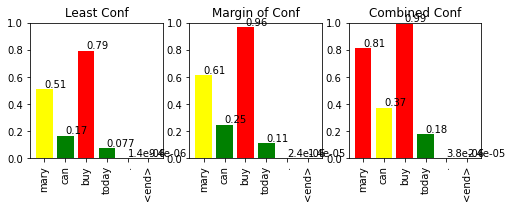


Target:  i'd like meat loaf .
Aggregate Sequence Uncertainty: 0.23400235176086426

Input: <start> הייתי רוצה קציצה . <end>
Predicted translation: i'd want meat loaf . <end> 
Runner-up translation: i like to . cream fuji 


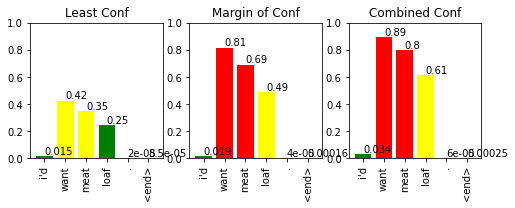


Target:  keep an open mind .
Aggregate Sequence Uncertainty: 0.2333691254258156

Input: <start> שמור על ראש פתוח . <end>
Predicted translation: keep my desk . <end> 
Runner-up translation: stay clean room ! . 


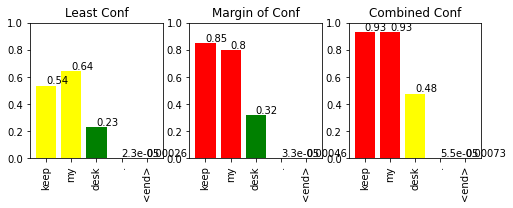


Target:  tom's surprised .
Aggregate Sequence Uncertainty: 0.2331793922930956

Input: <start> תום נדהם . <end>
Predicted translation: tom is baffled . <end> 
Runner-up translation: tom's was astonished ! . 


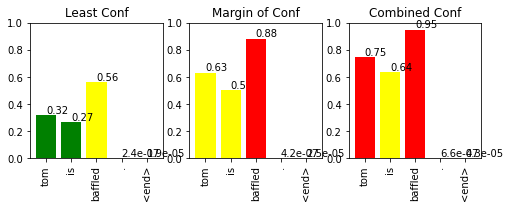


Target:  make a decision .
Aggregate Sequence Uncertainty: 0.23242667093873023

Input: <start> החלט . <end>
Predicted translation: i will die . <end> 
Runner-up translation: you was continue ! . 


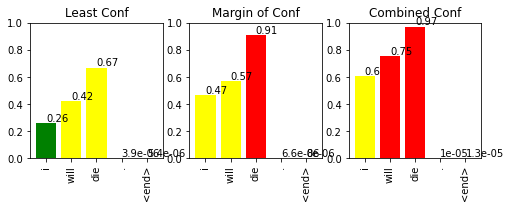


Target:  i love music , too .
Aggregate Sequence Uncertainty: 0.23137583583593369

Input: <start> אני אוהבת גם מוזיקה . <end>
Predicted translation: i like music , too . <end> 
Runner-up translation: i'm love boston . music music myself 


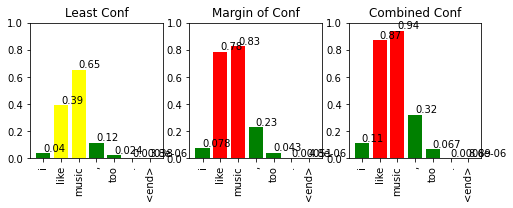


Target:  am i making sense ?
Aggregate Sequence Uncertainty: 0.22898766845464708

Input: <start> האם יש היגיון בדברים שלי ? <end>
Predicted translation: is my own ? <end> 
Runner-up translation: was i ear bad me 


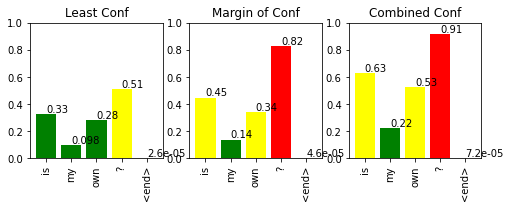


Target:  i see your pen .
Aggregate Sequence Uncertainty: 0.22812032997608184

Input: <start> אני רואה את העט שלך . <end>
Predicted translation: i can your pen . <end> 
Runner-up translation: i'm see buy sweater ? i 


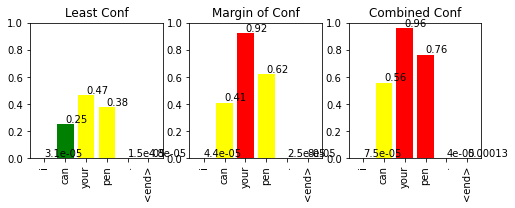


Target:  tom is inspired .
Aggregate Sequence Uncertainty: 0.22609021998941897

Input: <start> נחה הרוח על תום . <end>
Predicted translation: people stayed tom . <end> 
Runner-up translation: tom ended away ! tom 


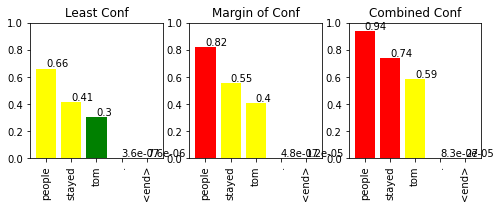


Target:  they got tired .
Aggregate Sequence Uncertainty: 0.2252144063822925

Input: <start> הם התעייפו . <end>
Predicted translation: they are traitors . <end> 
Runner-up translation: they're were afraid ! . 


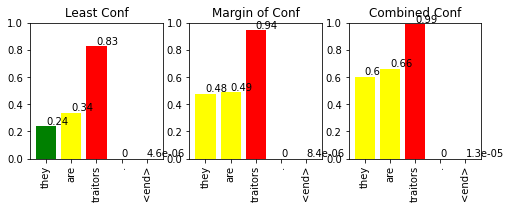


Target:  is anybody hurt ?
Aggregate Sequence Uncertainty: 0.22448647655546666

Input: <start> יש נפגעים ? <end>
Predicted translation: did you have a point ? <end> 
Runner-up translation: anybody i hurt done key . me 


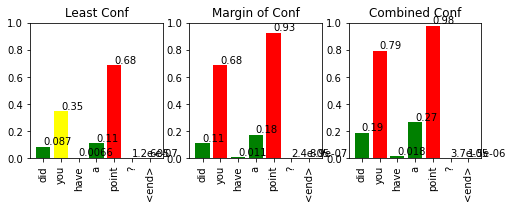


Target:  eat slowly .
Aggregate Sequence Uncertainty: 0.22205884084105493

Input: <start> אכול לאט . <end>
Predicted translation: eat the noise . <end> 
Runner-up translation: i a toddler won fuji 


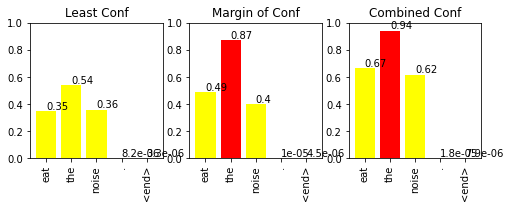


Target:  a fuse has blown .
Aggregate Sequence Uncertainty: 0.22114699184894562

Input: <start> הפיוז הלך . <end>
Predicted translation: a fuse is up . <end> 
Runner-up translation: my revolt has gone to fuji 


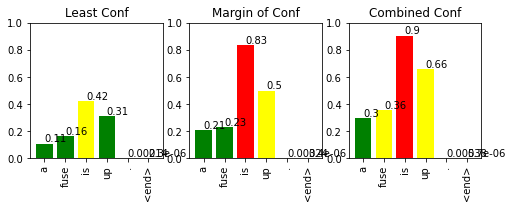


Target:  it does happen .
Aggregate Sequence Uncertainty: 0.21927257720381021

Input: <start> זה אכן קורה . <end>
Predicted translation: it did be true . <end> 
Runner-up translation: that is happens fatal again fuji 


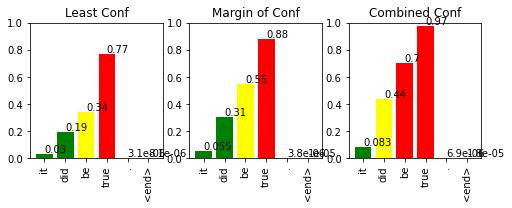


Target:  just settle down .
Aggregate Sequence Uncertainty: 0.21886079953983426

Input: <start> פשוט תרגע . <end>
Predicted translation: just take a number . <end> 
Runner-up translation: now settle easy jerk ! . 


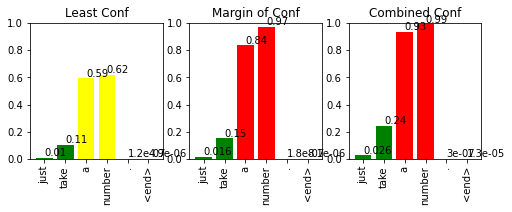


Target:  keep away from me .
Aggregate Sequence Uncertainty: 0.2180940616875887

Input: <start> אל תתקרבי אלי . <end>
Predicted translation: don't go to me . <end> 
Runner-up translation: keep leave away leave mad me 


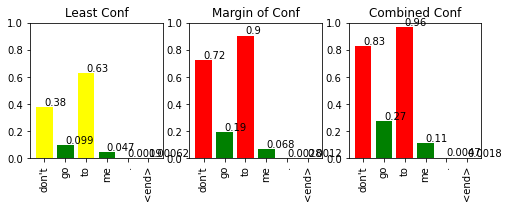


Target:  this time i'll pay .
Aggregate Sequence Uncertainty: 0.2135159086436033

Input: <start> הפעם אני משלם . <end>
Predicted translation: you play . <end> 
Runner-up translation: this eat i'll i 


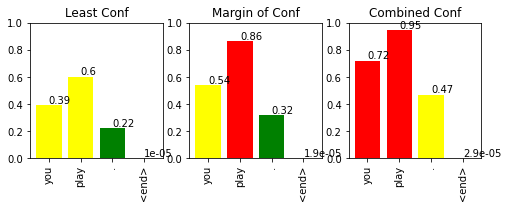


Target:  have some respect .
Aggregate Sequence Uncertainty: 0.21346232369542123

Input: <start> תן קצת כבוד . <end>
Predicted translation: come some respect . <end> 
Runner-up translation: take a eggnog please i 


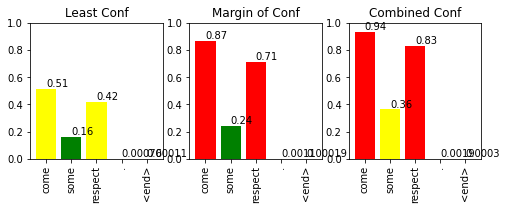


Target:  i still don't know .
Aggregate Sequence Uncertainty: 0.21266829073429108

Input: <start> איני יודע עדיין . <end>
Predicted translation: i still know . <end> 
Runner-up translation: i'm don't don't yet . 


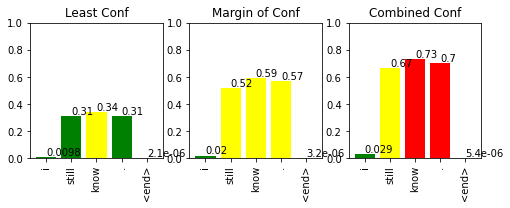


Target:  it's going nicely !
Aggregate Sequence Uncertainty: 0.2112962540326407

Input: <start> זה מתקדם יפה ! <end>
Predicted translation: it's getting freezing ! <end> 
Runner-up translation: it bedtime safe now fuji 


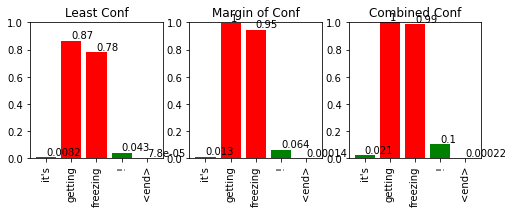


Target:  don't trust anybody .
Aggregate Sequence Uncertainty: 0.21128018759191036

Input: <start> אל תאמיני לכל אחד . <end>
Predicted translation: don't count all . <end> 
Runner-up translation: keep trust up wet . 


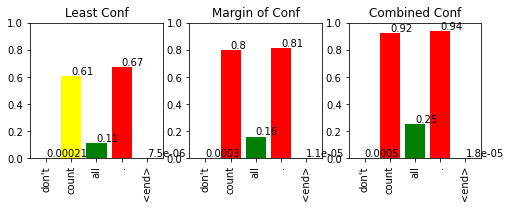


Target:  hurry it up .
Aggregate Sequence Uncertainty: 0.20899457968771457

Input: <start> תזרז את זה . <end>
Predicted translation: shut it up . <end> 
Runner-up translation: knock that off ! . 


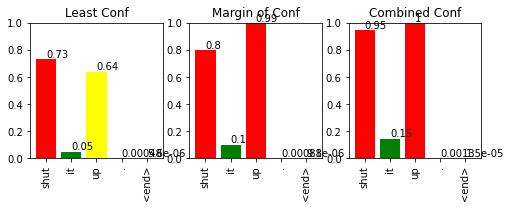


Target:  i groaned .
Aggregate Sequence Uncertainty: 0.20847344072535634

Input: <start> נאנקתי . <end>
Predicted translation: i was screaming . <end> 
Runner-up translation: i've groaned disgusted ! fuji 


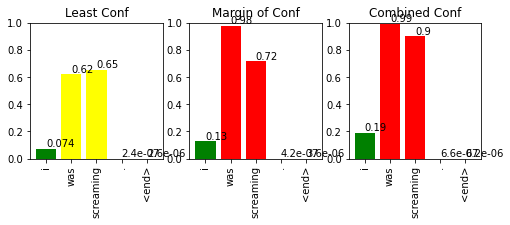


Target:  i will try it again .
Aggregate Sequence Uncertainty: 0.2083126813173294

Input: <start> אני אנסה שוב . <end>
Predicted translation: i'm in again . <end> 
Runner-up translation: i at try again . 


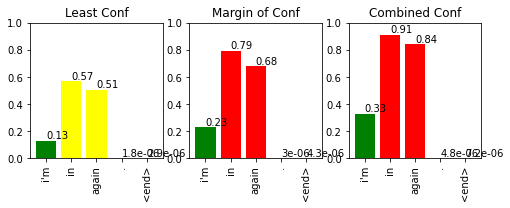


Target:  go take a walk .
Aggregate Sequence Uncertainty: 0.20825453400611876

Input: <start> לך לטייל . <end>
Predicted translation: go have to me fun . <end> 
Runner-up translation: you to some fun . to me 


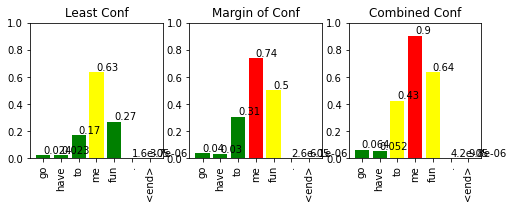


Target:  who's at fault ?
Aggregate Sequence Uncertainty: 0.20823627822101115

Input: <start> אשמת מי ? <end>
Predicted translation: who's at us ? <end> 
Runner-up translation: whose of fault . i 


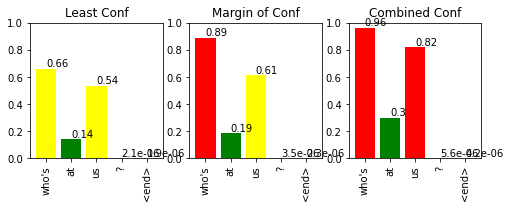


Target:  i'm done for today .
Aggregate Sequence Uncertainty: 0.20605100691318512

Input: <start> סיימתי להיום . <end>
Predicted translation: i'm done a day . <end> 
Runner-up translation: i finished all pen was i 


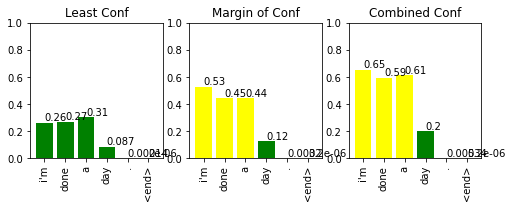


Target:  i get the point .
Aggregate Sequence Uncertainty: 0.205859661847353

Input: <start> הבנתי את הענין . <end>
Predicted translation: i dried the park . <end> 
Runner-up translation: i've blow a shots tire . 


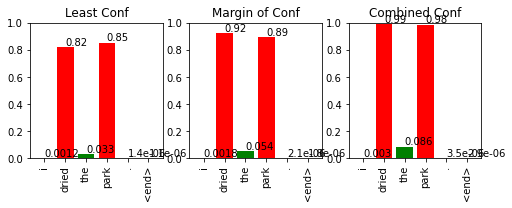


Target:  i think tom is old .
Aggregate Sequence Uncertainty: 0.20563684441149235

Input: <start> אני חושבת שתום קשיש . <end>
Predicted translation: i think it's old . <end> 
Runner-up translation: i'm guess tom apple is i 


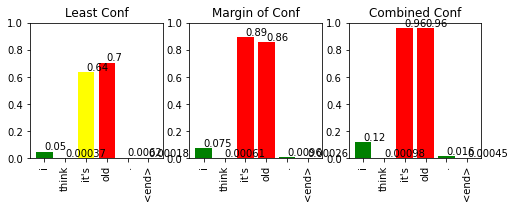


Target:  i have a white cat .
Aggregate Sequence Uncertainty: 0.2047572337090969

Input: <start> יש לי חתול לבן . <end>
Predicted translation: i have a huge tire . <end> 
Runner-up translation: i'm got big partner bike today myself 


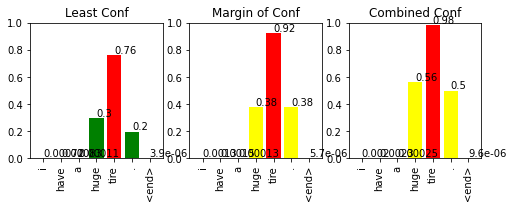


Target:  it's a nice day .
Aggregate Sequence Uncertainty: 0.2023603104054928

Input: <start> יום יפה היום . <end>
Predicted translation: it's a day day . <end> 
Runner-up translation: the an good left today today 


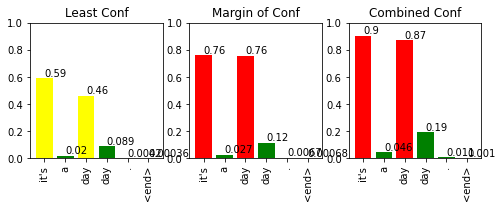


Target:  i grunted .
Aggregate Sequence Uncertainty: 0.2000995041918941

Input: <start> רטנתי . <end>
Predicted translation: i was drugged . <end> 
Runner-up translation: i'm disagreed jumping player fuji 


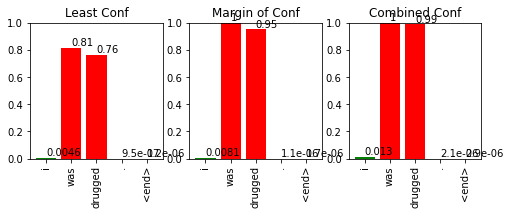

(array([], dtype=float64), array([], dtype=float64))

In [89]:
get_ranked_uncertainty(val_sequences_means, len(val_unsure_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_unsure_non_matches, results=val_results)

Wow!  Pretty bad stuff there - but that was exactly what we were looking for as candidates for a first pass in an Active Learning cycle.  Also, it shows that the model is aware of its "known unknowns".  Finally, let's touch on the overall look of the validation set apart from the high uncertainty set:

In [103]:
val_matches, val_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size-val_high_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set less confused matches: " + str(len(val_matches)))
print("Validation set less confused non-Matches: " + str(len(val_non_matches)))
print("Matching: {:.1%}".format((len(val_matches)/(len(val_matches)+len(val_non_matches)))))

Validation set less confused matches: 454
Validation set less confused non-Matches: 462
Matching ratio: 49.6%


In this run, about half are matching, and therefore known to be accurate - much better than our highly uncertain set.  And of course, many of these non-matches may be viable translations.  Playing with and optimizing the thresholds should help here.

## Thanks! (and next steps)
  - ignore end of sentence token for aggregate certainty score
  - try Entropy score? - not sure that will tell us more than what we have here but may surprise us
  - play with and optimize the thresholds
    * manually to start?
    * using ML
  - try longer sentences
  - try different base in a custom softmax function (per Robert Munro)
  - Reverse source and target (non-English targets)
  - try aggregation by minimum token confidence in sequence
  - use another algorithm (e.g. Transformers)

